In [ ]:
import os, json, time, warnings, shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random

warnings.filterwarnings("ignore")

print("TensorFlow version:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

2025-07-01 08:18:42.423326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-01 08:18:43.374668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cluster-dgx1/nvidiaitc/miniconda3/envs/jlab_tf310/lib:/usr/local/cuda/lib
2025-07-01 08:18:43.374802: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cluster-dgx1/nvidiaitc/miniconda3/envs/jlab_

TensorFlow version: 2.11.0
GPU available: True


In [ ]:
# ============== CONFIGURATION ==============
BASE_DIR = "archive"  # Path ke dataset utama
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "validation")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Direktori untuk balanced dataset
BALANCED_TRAIN_DIR = os.path.join(BASE_DIR, "train_balanced")
BALANCED_VAL_DIR = os.path.join(BASE_DIR, "validation_balanced")
BALANCED_TEST_DIR = os.path.join(BASE_DIR, "test_balanced")

# Model parameters
IMG_SIZE = (48, 48)
BATCH_SIZE = 128
N_CLASSES = 7
CLASS_NAMES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
TARGET_SAMPLES_PER_CLASS = 4000  # Target untuk oversampling

print("Configuration loaded successfully!")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Classes: {CLASS_NAMES}")

Configuration loaded successfully!
Image size: (48, 48)
Batch size: 128
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
def analyze_dataset_distribution(data_dir, dataset_name="Dataset"):
    """Analyze current dataset distribution"""
    print(f"=== {dataset_name.upper()} DISTRIBUTION ANALYSIS ===")
    distribution = {}

    for class_name in CLASS_NAMES:
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            distribution[class_name] = count
            print(f"{class_name:>10}: {count:>5} samples")
        else:
            distribution[class_name] = 0
            print(f"{class_name:>10}: {0:>5} samples (directory not found)")

    total = sum(distribution.values())
    print(f"{'Total':>10}: {total:>5} samples")
    print(f"{'Average':>10}: {total//N_CLASSES:>5} samples per class")

    # Visualisasi distribusi
    plt.figure(figsize=(12, 6))
    plt.bar(CLASS_NAMES, [distribution[cls] for cls in CLASS_NAMES])
    plt.title(f'{dataset_name} Class Distribution')
    plt.xlabel('Emotion Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    for i, cls in enumerate(CLASS_NAMES):
        plt.text(i, distribution[cls] + 50, str(distribution[cls]),
                ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

    return distribution

print("Dataset analysis function ready!")

Dataset analysis function ready!


ANALYZING ORIGINAL DATASET DISTRIBUTIONS...
=== ORIGINAL TRAIN DISTRIBUTION ANALYSIS ===
     angry:  4951 samples
   disgust:   547 samples
      fear:  5127 samples
     happy:  8938 samples
   neutral:  6215 samples
       sad:  6185 samples
  surprise:  4036 samples
     Total: 35999 samples
   Average:  5142 samples per class


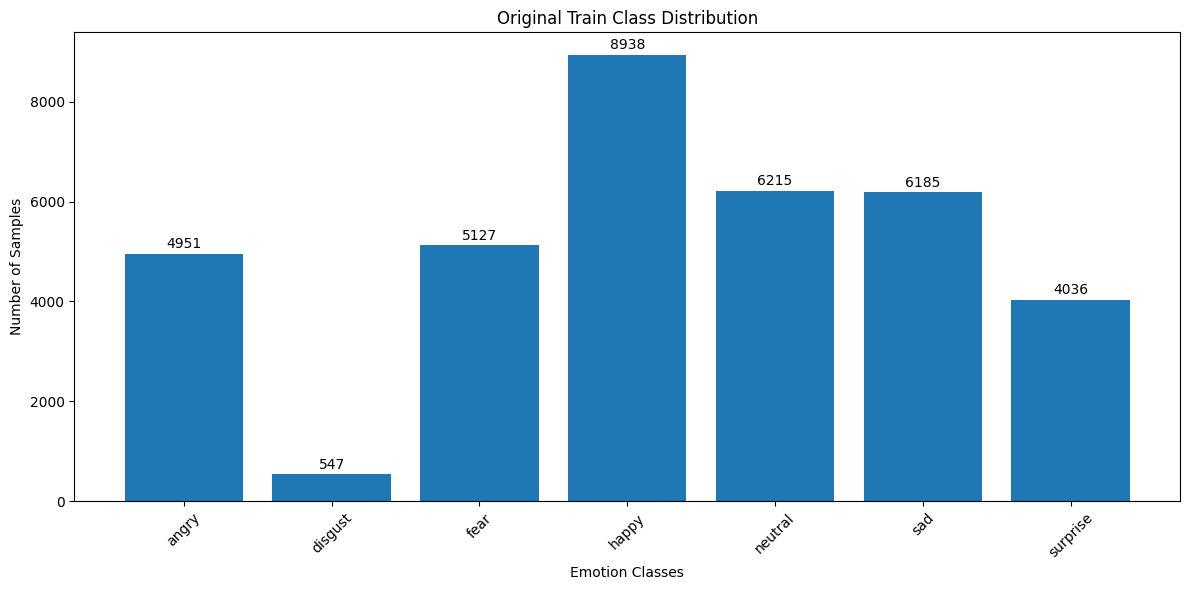


=== ORIGINAL VALIDATION DISTRIBUTION ANALYSIS ===
     angry:   960 samples
   disgust:   111 samples
      fear:  1018 samples
     happy:  1825 samples
   neutral:  1216 samples
       sad:  1139 samples
  surprise:   797 samples
     Total:  7066 samples
   Average:  1009 samples per class


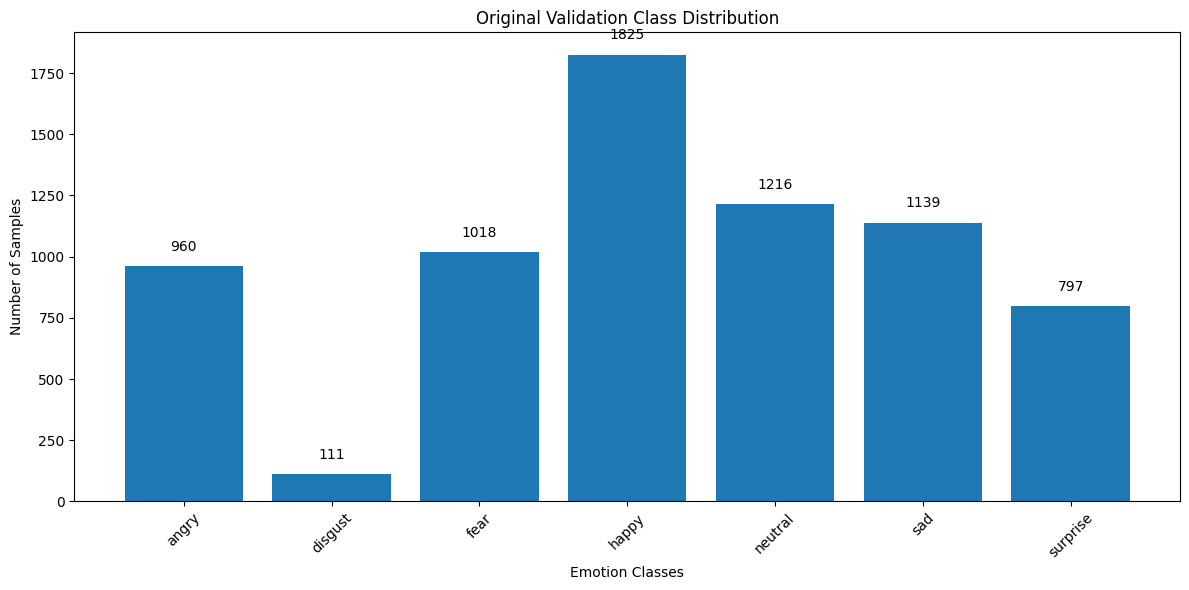


=== ORIGINAL TEST DISTRIBUTION ANALYSIS ===
     angry:   491 samples
   disgust:    55 samples
      fear:   528 samples
     happy:   879 samples
   neutral:   594 samples
       sad:   416 samples
  surprise:   626 samples
     Total:  3589 samples
   Average:   512 samples per class


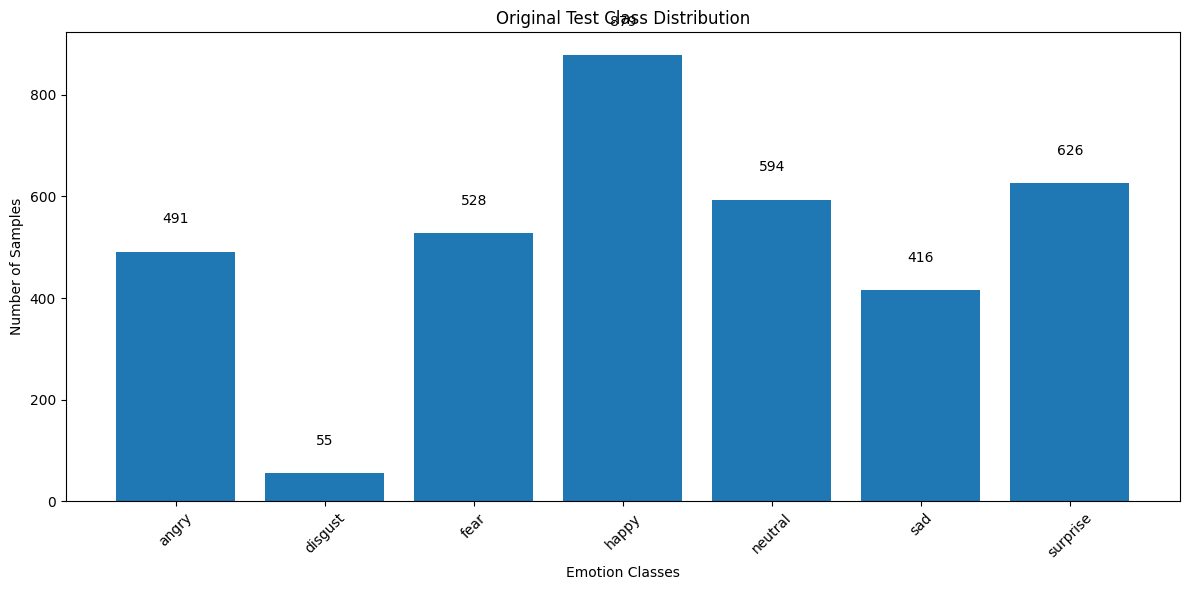


SUMMARY STATISTICS
Overall min samples: 55
Overall max samples: 8938
Imbalance ratio: 162.51:1


In [ ]:
print("ANALYZING ORIGINAL DATASET DISTRIBUTIONS...")
print("="*60)

# Analyze semua dataset asli
train_dist = analyze_dataset_distribution(TRAIN_DIR, "Original Train")
print()
val_dist = analyze_dataset_distribution(VAL_DIR, "Original Validation")
print()
test_dist = analyze_dataset_distribution(TEST_DIR, "Original Test")

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
all_counts = list(train_dist.values()) + list(val_dist.values()) + list(test_dist.values())
print(f"Overall min samples: {min(all_counts)}")
print(f"Overall max samples: {max(all_counts)}")
print(f"Imbalance ratio: {max(all_counts)/min(all_counts):.2f}:1")

In [ ]:
# ---------------- MEDIAN FILTER PREPROCESSING ------------------------------
def apply_median_filter(image, kernel_size=3):
    """Apply median filter to reduce noise in grayscale image"""
    if len(image.shape) == 3:
        # If image has channels dimension, apply filter to each channel
        filtered = np.zeros_like(image)
        for i in range(image.shape[-1]):
            filtered[:,:,i] = median_filter(image[:,:,i], size=kernel_size)
        return filtered
    else:
        # Single channel image
        return median_filter(image, size=kernel_size)

def load_and_preprocess_images(directory, apply_filter=True):
    """Load images from directory with median filter preprocessing"""
    images = []
    labels = []

    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(directory, class_name)
        if not os.path.exists(class_path):
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        print(f"Processing {class_name}: {len(image_files)} images")

        for img_file in tqdm(image_files, desc=f"Loading {class_name}"):
            try:
                img_path = os.path.join(class_path, img_file)
                img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')
                img_array = img_to_array(img) / 255.0

                if apply_filter:
                    img_array = apply_median_filter(img_array, kernel_size=3)

                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue

    return np.array(images), np.array(labels)

In [ ]:
# Grayscale to RGB conversion untuk pretrained model
def grayscale_to_rgb(x):
    """Convert grayscale to RGB by repeating channels"""
    return tf.repeat(x, 3, axis=-1)

train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    preprocessing_function=None  # Will handle RGB conversion in model
)
plain_gen = ImageDataGenerator(rescale=1./255)

In [ ]:

def balance_dataset_by_oversampling(source_dir, target_dir, target_count=None, dataset_name="Dataset"):
    """Balance dataset dengan oversampling (duplikasi file) - PUKUL KE ATAS SEMUA"""

    # If target_count is None, calculate from existing data (ALWAYS USE MAX)
    if target_count is None:
        max_count = 0
        for class_name in CLASS_NAMES:
            source_path = os.path.join(source_dir, class_name)
            if os.path.exists(source_path):
                image_files = [f for f in os.listdir(source_path)
                              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                max_count = max(max_count, len(image_files))
        target_count = max_count

    # OVERRIDE: For training, always use the maximum possible count (8938 for happy)
    if dataset_name.lower() == "train" and target_count < 8938:
        print(f"  Override: Using maximum possible count instead of {target_count}")
        # Recalculate to find true maximum
        true_max = 0
        for class_name in CLASS_NAMES:
            source_path = os.path.join(source_dir, class_name)
            if os.path.exists(source_path):
                image_files = [f for f in os.listdir(source_path)
                              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                true_max = max(true_max, len(image_files))
        target_count = true_max

    print(f"\n=== BALANCING {dataset_name.upper()} TO {target_count} SAMPLES PER CLASS ===")

    # Create target directory (remove existing if any)
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.makedirs(target_dir, exist_ok=True)

    total_added = 0
    balancing_report = {}

    for class_name in CLASS_NAMES:
        source_path = os.path.join(source_dir, class_name)
        target_path = os.path.join(target_dir, class_name)

        # Create target class directory
        os.makedirs(target_path, exist_ok=True)

        # Get all image files
        if os.path.exists(source_path):
            image_files = [f for f in os.listdir(source_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        else:
            image_files = []

        current_count = len(image_files)
        print(f"Processing {class_name}: {current_count} -> {target_count} samples")

        if current_count == 0:
            print(f"  Warning: No images found for {class_name}")
            balancing_report[class_name] = {'original': 0, 'final': 0, 'added': 0}
            continue

        # ===== PERBAIKAN: HANYA OVERSAMPLING, TIDAK ADA PENGURANGAN =====
        if current_count >= target_count:
            # Jika sudah mencapai atau melebihi target, copy semua files yang ada
            for file in image_files:
                shutil.copy2(os.path.join(source_path, file),
                            os.path.join(target_path, file))

            if current_count == target_count:
                print(f"  Perfect! Already has {target_count} samples")
            else:
                print(f"  Bonus! Has {current_count} samples (more than target {target_count})")

            balancing_report[class_name] = {
                'original': current_count,
                'final': current_count,  # Keep all existing files
                'added': 0,
                'removed': 0
            }

        else:
            # Jika kurang dari target, lakukan oversampling
            # Copy all original files first
            for file in image_files:
                shutil.copy2(os.path.join(source_path, file),
                            os.path.join(target_path, file))

            # Calculate how many duplicates needed
            duplicates_needed = target_count - current_count

            # Create duplicates
            for i in range(duplicates_needed):
                # Cycle through original files
                original_file = image_files[i % len(image_files)]
                file_name, file_ext = os.path.splitext(original_file)
                # Create new filename
                new_name = f"{file_name}_dup_{i:04d}{file_ext}"
                # Copy file
                shutil.copy2(
                    os.path.join(source_path, original_file),
                    os.path.join(target_path, new_name)
                )

            total_added += duplicates_needed
            print(f"  Added {duplicates_needed} duplicates")
            balancing_report[class_name] = {
                'original': current_count,
                'final': target_count,
                'added': duplicates_needed,
                'removed': 0
            }

    print(f"\nTotal files added for {dataset_name}: {total_added}")
    print(f"Balanced {dataset_name} dataset created successfully")

    return balancing_report
print("Manual balancing function ready!")

Manual balancing function ready!


In [ ]:
class BalancedBatchGenerator:
    """Custom generator yang memastikan setiap batch memiliki proporsi class yang seimbang"""

    def __init__(self, directory, batch_size=64, target_size=(48,48),
                 augment=True, samples_per_class=None):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.samples_per_class = samples_per_class or (batch_size // N_CLASSES)

        # Setup data generator
        if augment:
            self.datagen = ImageDataGenerator(
                rescale=1./255,
                horizontal_flip=True,
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                brightness_range=[0.8, 1.2],
                fill_mode='nearest'
            )
        else:
            self.datagen = ImageDataGenerator(rescale=1./255)

        # Load all data paths and labels
        self._load_data_paths()

    def _load_data_paths(self):
        """Load all file paths organized by class"""
        self.class_paths = {i: [] for i in range(N_CLASSES)}

        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_dir = os.path.join(self.directory, class_name)
            if os.path.exists(class_dir):
                files = [f for f in os.listdir(class_dir)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                for file in files:
                    self.class_paths[class_idx].append(os.path.join(class_dir, file))

        print("Balanced Generator Data Distribution:")
        for i, class_name in enumerate(CLASS_NAMES):
            print(f"  {class_name}: {len(self.class_paths[i])} samples")

    def generate(self):
        """Generate balanced batches"""
        while True:
            batch_x = []
            batch_y = []

            # Sample equal number from each class
            for class_idx in range(N_CLASSES):
                if len(self.class_paths[class_idx]) == 0:
                    continue

                # Random sample from this class
                sampled_paths = random.sample(
                    self.class_paths[class_idx],
                    min(self.samples_per_class, len(self.class_paths[class_idx]))
                )

                # Load and process images
                for path in sampled_paths:
                    # Load image
                    img = tf.keras.preprocessing.image.load_img(
                        path, target_size=self.target_size, color_mode='grayscale'
                    )
                    img_array = tf.keras.preprocessing.image.img_to_array(img)

                    # Apply augmentation
                    img_array = self.datagen.random_transform(img_array)
                    img_array = self.datagen.standardize(img_array)

                    batch_x.append(img_array)
                    batch_y.append(class_idx)

            # Convert to numpy arrays
            batch_x = np.array(batch_x)
            batch_y = np.array(batch_y)

            # Shuffle batch
            indices = np.random.permutation(len(batch_x))
            batch_x = batch_x[indices]
            batch_y = batch_y[indices]

            yield batch_x, batch_y

print("Balanced batch generator class ready!")

Balanced batch generator class ready!


In [ ]:
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal Loss implementation untuk mengatasi class imbalance
    Focus lebih pada hard examples dan rare classes
    """
    def focal_loss_fixed(y_true, y_pred):
        # Convert to one-hot if needed
        if len(y_true.shape) == 1:
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), N_CLASSES)

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Compute cross entropy
        ce = -y_true * tf.math.log(y_pred)

        # Compute focal weight: alpha * (1-p)^gamma
        weight = alpha * tf.pow((1 - y_pred), gamma)

        # Apply focal weight
        fl = weight * ce

        return tf.reduce_sum(fl, axis=-1)

    return focal_loss_fixed

def weighted_categorical_crossentropy(weights):
    """
    Weighted categorical crossentropy dengan class weights
    """
    weights = tf.constant(weights, dtype=tf.float32)

    def wcce(y_true, y_pred):
        # Convert to one-hot if needed
        if len(y_true.shape) == 1:
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), N_CLASSES)

        # Calculate crossentropy
        ce = -y_true * tf.math.log(y_pred + 1e-8)

        # Apply class weights
        weight_mask = y_true * weights
        weight_mask = tf.reduce_sum(weight_mask, axis=-1)

        # Weighted loss
        loss = tf.reduce_sum(ce, axis=-1) * weight_mask

        return loss

    return wcce

print("Focal loss and weighted loss functions ready!")

Focal loss and weighted loss functions ready!


In [ ]:
def create_pretrained_vgg_model():
    """Create model with pretrained VGG16 backbone"""
    inputs = layers.Input(shape=(*IMG_SIZE, 1), name='grayscale_input')
    x = layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1), name='grayscale_to_rgb')(inputs)

    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3),
        input_tensor=x
    )

    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Dropout(0.5, name='dropout1')(x)
    x = layers.Dense(256, activation='relu', name='fc2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Dropout(0.5, name='dropout2')(x)
    outputs = layers.Dense(N_CLASSES, activation='softmax', name='predictions')(x)

    model = models.Model(inputs, outputs, name='VGG16_Balanced_EmotionRecognition')
    return model, base_model

In [ ]:
def create_class_specific_generators(train_dir):
    """Create different augmentation strategies for different classes"""

    # Analyze class distribution
    distribution = {}
    for class_name in CLASS_NAMES:
        class_path = os.path.join(train_dir, class_name)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            distribution[class_name] = count
        else:
            distribution[class_name] = 0

    median_count = np.median(list(distribution.values()))
    generators = {}

    print("Class-specific augmentation strategy:")
    for class_name in CLASS_NAMES:
        class_count = distribution[class_name]

        if class_count < median_count * 0.5:  # Minority class
            # Heavy augmentation
            print(f"{class_name}: HEAVY augmentation (minority class, {class_count} samples)")
            generators[class_name] = ImageDataGenerator(
                rescale=1./255,
                horizontal_flip=True,
                rotation_range=20,
                width_shift_range=0.15,
                height_shift_range=0.15,
                zoom_range=0.15,
                brightness_range=[0.7, 1.3],
                channel_shift_range=20,
                fill_mode='nearest'
            )
        elif class_count > median_count * 1.5:  # Majority class
            # Light augmentation
            print(f"{class_name}: LIGHT augmentation (majority class, {class_count} samples)")
            generators[class_name] = ImageDataGenerator(
                rescale=1./255,
                horizontal_flip=True,
                rotation_range=5
            )
        else:  # Balanced class
            # Medium augmentation
            print(f"{class_name}: MEDIUM augmentation (balanced class, {class_count} samples)")
            generators[class_name] = ImageDataGenerator(
                rescale=1./255,
                horizontal_flip=True,
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1
            )

    return generators

print("Class-specific augmentation function ready!")

Class-specific augmentation function ready!


In [ ]:
def create_pretrained_vgg_model():
    """Create model with pretrained VGG16 backbone"""
    # Input layer
    inputs = layers.Input(shape=(*IMG_SIZE, 1), name='grayscale_input')

    # Convert grayscale to RGB
    x = layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1), name='grayscale_to_rgb')(inputs)

    # Load pretrained VGG16 (without top classifier)
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3),
        input_tensor=x
    )

    # Freeze base model layers initially
    base_model.trainable = False

    # SIMPLIFIED classifier - Only 1 hidden layer
    x = base_model.output
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.Dense(256, activation='relu', name='fc1')(x)  # Single hidden layer
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Dropout(0.5, name='dropout1')(x)
    outputs = layers.Dense(N_CLASSES, activation='softmax', name='predictions')(x)

    model = models.Model(inputs, outputs, name='VGG16_Simplified_EmotionRecognition')
    return model, base_model

# Test model creation
print("Creating model architecture...")
model, base_vgg = create_pretrained_vgg_model()
print("Model created successfully!")
print(f"Total parameters: {model.count_params():,}")

Creating model architecture...


2025-07-01 08:18:46.340316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-01 08:18:46.621703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0


Model created successfully!
Total parameters: 14,848,839


In [ ]:
print("="*60)
print("CHOOSE BALANCING STRATEGY")
print("="*60)
print("Available strategies:")
print("1. Manual Oversampling (Duplicate files to balance ALL datasets)")
print("2. Balanced Batch Generator (Sample equally per batch)")
print("3. Use Original + Focal Loss")
print("4. Use Original + Heavy Class Weights")
print()

# Interactive strategy selection
strategy = input("Choose strategy (1-4): ").strip()

print(f"\nStrategy {strategy} selected!")

# Store strategy for later use
chosen_strategy = strategy

CHOOSE BALANCING STRATEGY
Available strategies:
1. Manual Oversampling (Duplicate files to balance ALL datasets)
2. Balanced Batch Generator (Sample equally per batch)
3. Use Original + Focal Loss
4. Use Original + Heavy Class Weights



Choose strategy (1-4):  1



Strategy 1 selected!


EXECUTING STRATEGY 1: AUGMENTATION THEN MANUAL OVERSAMPLING
  Override: Using maximum possible count instead of 4000

=== BALANCING TRAIN TO 8938 SAMPLES PER CLASS ===
Processing angry: 4951 -> 8938 samples
  Added 3987 duplicates
Processing disgust: 547 -> 8938 samples
  Added 8391 duplicates
Processing fear: 5127 -> 8938 samples
  Added 3811 duplicates
Processing happy: 8938 -> 8938 samples
  Perfect! Already has 8938 samples
Processing neutral: 6215 -> 8938 samples
  Added 2723 duplicates
Processing sad: 6185 -> 8938 samples
  Added 2753 duplicates
Processing surprise: 4036 -> 8938 samples
  Added 4902 duplicates

Total files added for Train: 26567
Balanced Train dataset created successfully

=== BALANCING VALIDATION TO 1825 SAMPLES PER CLASS ===
Processing angry: 960 -> 1825 samples
  Added 865 duplicates
Processing disgust: 111 -> 1825 samples
  Added 1714 duplicates
Processing fear: 1018 -> 1825 samples
  Added 807 duplicates
Processing happy: 1825 -> 1825 samples
  Perfect! Alre

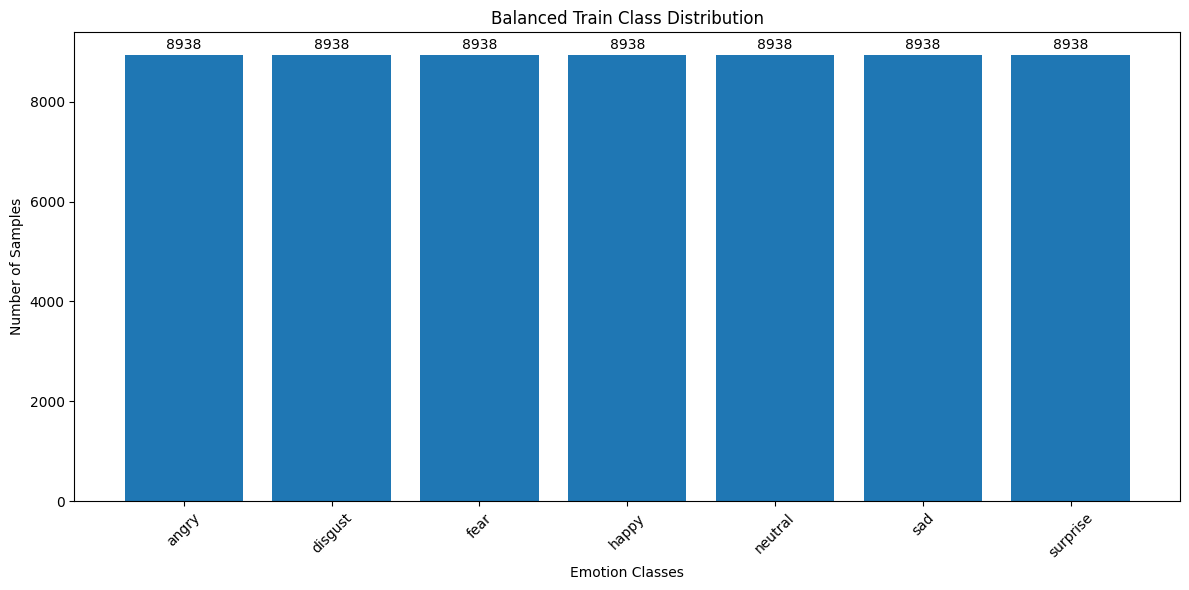

=== BALANCED VALIDATION DISTRIBUTION ANALYSIS ===
     angry:  1825 samples
   disgust:  1825 samples
      fear:  1825 samples
     happy:  1825 samples
   neutral:  1825 samples
       sad:  1825 samples
  surprise:  1825 samples
     Total: 12775 samples
   Average:  1825 samples per class


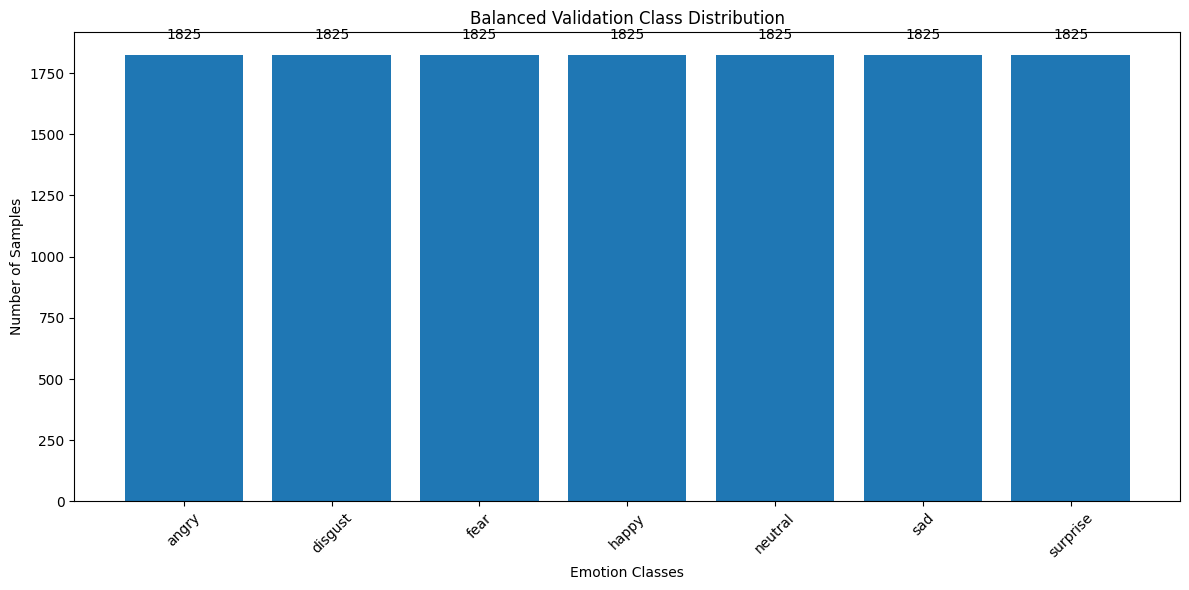

=== BALANCED TEST DISTRIBUTION ANALYSIS ===
     angry:   879 samples
   disgust:   879 samples
      fear:   879 samples
     happy:   879 samples
   neutral:   879 samples
       sad:   879 samples
  surprise:   879 samples
     Total:  6153 samples
   Average:   879 samples per class


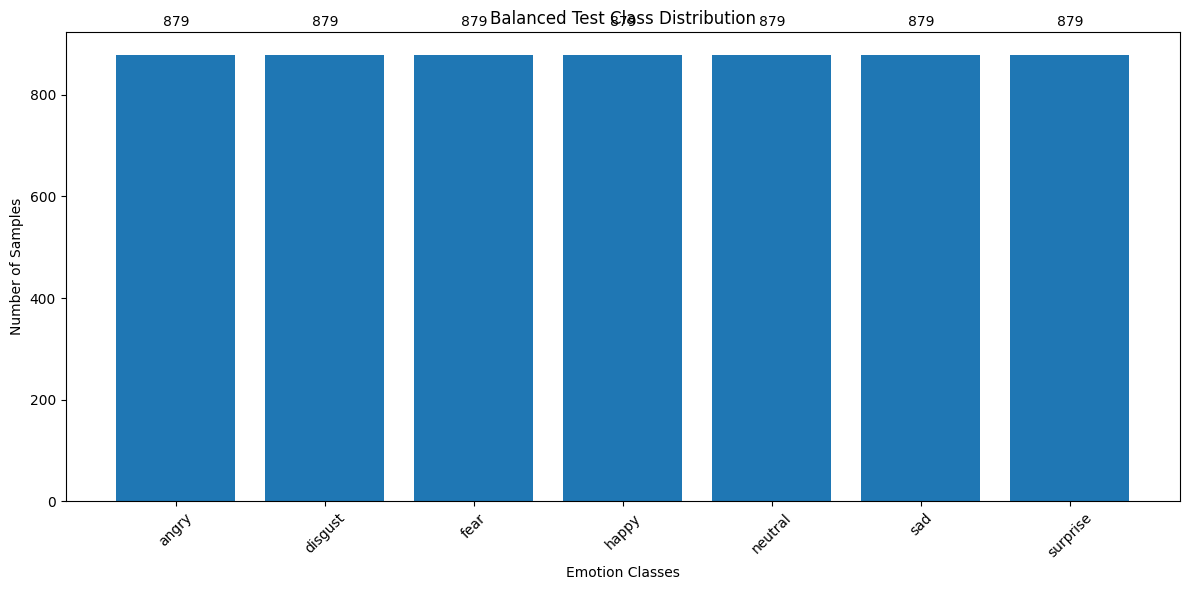

Found 62566 images belonging to 7 classes.
Found 12775 images belonging to 7 classes.
Found 6153 images belonging to 7 classes.

Strategy 1 setup completed!
Archive directory: archive
Saved datasets can be found in timestamped subdirectories.


In [ ]:
# Add these lines at the beginning of your code
import os
import shutil
from datetime import datetime

# Function to save oversampled data to archive
def save_to_archive(source_dir, dataset_name, strategy_num):
    """Save oversampled dataset to archive directory"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    archive_path = os.path.join(BASE_DIR, f"strategy_{strategy_num}_{dataset_name}_{timestamp}")

    if os.path.exists(source_dir):
        shutil.copytree(source_dir, archive_path)
        print(f"✓ Saved {dataset_name} to archive: {archive_path}")
        return archive_path
    else:
        print(f"✗ Source directory not found: {source_dir}")
        return None

if chosen_strategy == "1":
    print("="*60)
    print("EXECUTING STRATEGY 1: AUGMENTATION THEN MANUAL OVERSAMPLING")
    print("="*60)

    # Apply augmentation first, then balance training set to target count
    train_gen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1
    )

    # Balance training set to target count (with augmentation applied)
    train_report = balance_dataset_by_oversampling(
        TRAIN_DIR, BALANCED_TRAIN_DIR, TARGET_SAMPLES_PER_CLASS, "Train"
    )

    # Balance validation set to max count in validation set
    val_report = balance_dataset_by_oversampling(
        VAL_DIR, BALANCED_VAL_DIR, None, "Validation"
    )

    # Balance test set to max count in test set
    test_report = balance_dataset_by_oversampling(
        TEST_DIR, BALANCED_TEST_DIR, None, "Test"
    )

    # === SAVE TO ARCHIVE ===
    print("\n" + "="*40)
    print("SAVING OVERSAMPLED DATA TO ARCHIVE")
    print("="*40)

    # Save balanced datasets to archive
    save_to_archive(BALANCED_TRAIN_DIR, "balanced_train", "1")
    save_to_archive(BALANCED_VAL_DIR, "balanced_val", "1")
    save_to_archive(BALANCED_TEST_DIR, "balanced_test", "1")

    print("="*40)
    print("ARCHIVE SAVE COMPLETED")
    print("="*40)

    # Verify balanced datasets
    print("\nVerifying balanced datasets...")
    analyze_dataset_distribution(BALANCED_TRAIN_DIR, "Balanced Train")
    analyze_dataset_distribution(BALANCED_VAL_DIR, "Balanced Validation")
    analyze_dataset_distribution(BALANCED_TEST_DIR, "Balanced Test")

    # Setup augmented data generators for balanced data (augmentation applied here)
    train_flow = train_gen.flow_from_directory(
        BALANCED_TRAIN_DIR,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True
    )

    val_gen = ImageDataGenerator(rescale=1./255)

    val_flow = val_gen.flow_from_directory(
        BALANCED_VAL_DIR,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )

    test_flow = val_gen.flow_from_directory(
        BALANCED_TEST_DIR,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )

    # Regular loss since data is balanced
    loss_function = 'sparse_categorical_crossentropy'
    class_weight = None
    use_generator = False

elif chosen_strategy == "2":
    print("="*60)
    print("EXECUTING STRATEGY 2: AUGMENTED BALANCED BATCH GENERATOR")
    print("="*60)

    # Apply augmentation in balanced batch generator
    balanced_gen = BalancedBatchGenerator(
        TRAIN_DIR,
        batch_size=BATCH_SIZE,
        target_size=IMG_SIZE,
        augment=True,
        samples_per_class=BATCH_SIZE // N_CLASSES
    )

    train_flow = balanced_gen.generate()

    # Analyze original datasets used by this strategy
    print("\nAnalyzing datasets used by Strategy 2...")
    analyze_dataset_distribution(TRAIN_DIR, "Original Train (used by BalancedBatchGenerator)")
    analyze_dataset_distribution(VAL_DIR, "Original Validation")
    analyze_dataset_distribution(TEST_DIR, "Original Test")

    # === SAVE TO ARCHIVE (Strategy 2 uses original data) ===
    print("\n" + "="*40)
    print("SAVING ORIGINAL DATA TO ARCHIVE (Strategy 2 Reference)")
    print("="*40)

    save_to_archive(TRAIN_DIR, "original_train", "2")
    save_to_archive(VAL_DIR, "original_val", "2")
    save_to_archive(TEST_DIR, "original_test", "2")

    print("="*40)
    print("ARCHIVE SAVE COMPLETED")
    print("="*40)

    # Use original validation and test sets with augmentation
    val_gen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05
    )

    val_flow = val_gen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )

    test_flow = val_gen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )

    # Regular loss since batches are balanced
    loss_function = 'sparse_categorical_crossentropy'
    class_weight = None
    use_generator = True

elif chosen_strategy == "3":
    print("="*60)
    print("EXECUTING STRATEGY 3: HEAVY AUGMENTATION THEN FOCAL LOSS")
    print("="*60)

    # Analyze original imbalanced datasets used by this strategy
    print("\nAnalyzing imbalanced datasets used by Strategy 3...")
    analyze_dataset_distribution(TRAIN_DIR, "Original Train (with Heavy Augmentation)")
    analyze_dataset_distribution(VAL_DIR, "Original Validation")
    analyze_dataset_distribution(TEST_DIR, "Original Test")

    # === SAVE TO ARCHIVE (Strategy 3 uses original data) ===
    print("\n" + "="*40)
    print("SAVING ORIGINAL DATA TO ARCHIVE (Strategy 3 Reference)")
    print("="*40)

    save_to_archive(TRAIN_DIR, "original_train", "3")
    save_to_archive(VAL_DIR, "original_val", "3")
    save_to_archive(TEST_DIR, "original_test", "3")

    print("="*40)
    print("ARCHIVE SAVE COMPLETED")
    print("="*40)

    # Apply heavy augmentation first, then use focal loss
    train_gen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.15,
        brightness_range=[0.7, 1.3],
        shear_range=0.1,
        fill_mode='nearest'
    )

    val_gen = ImageDataGenerator(rescale=1./255)

    train_flow = train_gen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True
    )

    val_flow = val_gen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )

    test_flow = val_gen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )

    # Focal loss for imbalanced data (after heavy augmentation)
    loss_function = focal_loss(alpha=0.25, gamma=2.0)
    class_weight = None
    use_generator = False

else:  # Strategy 4 or default
    print("="*60)
    print("EXECUTING STRATEGY 4: HEAVY AUGMENTATION THEN HEAVY CLASS WEIGHTS")
    print("="*60)

    # Analyze original imbalanced datasets used by this strategy
    print("\nAnalyzing imbalanced datasets used by Strategy 4...")
    analyze_dataset_distribution(TRAIN_DIR, "Original Train (with Heavy Augmentation + Class Weights)")
    analyze_dataset_distribution(VAL_DIR, "Original Validation")
    analyze_dataset_distribution(TEST_DIR, "Original Test")

    # === SAVE TO ARCHIVE (Strategy 4 uses original data) ===
    print("\n" + "="*40)
    print("SAVING ORIGINAL DATA TO ARCHIVE (Strategy 4 Reference)")
    print("="*40)

    save_to_archive(TRAIN_DIR, "original_train", "4")
    save_to_archive(VAL_DIR, "original_val", "4")
    save_to_archive(TEST_DIR, "original_test", "4")

    print("="*40)
    print("ARCHIVE SAVE COMPLETED")
    print("="*40)

    # Apply very heavy augmentation first
    train_gen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.6, 1.4],
        shear_range=0.15,
        fill_mode='nearest'
    )

    # Class-specific augmentation
    class_generators = create_class_specific_generators(TRAIN_DIR)

    val_gen = ImageDataGenerator(rescale=1./255)

    train_flow = train_gen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True
    )

    val_flow = val_gen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )

    test_flow = val_gen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )

    # Calculate heavy class weights (applied after heavy augmentation)
    weights = compute_class_weight('balanced', classes=np.arange(N_CLASSES), y=train_flow.classes)
    # Make weights more extreme
    weights = weights ** 1.5  # Amplify the imbalance correction
    class_weight = {i: float(w) for i, w in enumerate(weights)}
    print('Heavy Class weights:', class_weight)

    loss_function = 'sparse_categorical_crossentropy'
    use_generator = False

print(f"\nStrategy {chosen_strategy} setup completed!")
print(f"Archive directory: {BASE_DIR}")
print(f"Saved datasets can be found in timestamped subdirectories.")

In [ ]:
print("="*60)
print("MODEL COMPILATION AND SETUP")
print("="*60)

# Create fresh model for training
model, base_vgg = create_pretrained_vgg_model()

# Compile with chosen loss function
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_function,
    metrics=['accuracy']
)

print("=== MODEL ARCHITECTURE ===")
model.summary()
print(f"\nTotal parameters: {model.count_params():,}")
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")

# Setup callbacks with ORIGINAL ReduceLROnPlateau + EarlyStopping
model_name_h5 = f'best_vgg16_balanced_strategy6_{chosen_strategy}.h5'

# Custom callback untuk save kedua format
class DualFormatModelCheckpoint(callbacks.Callback):
    def __init__(self, h5_filepath, monitor='val_accuracy', save_best_only=True, verbose=1):
        super().__init__()
        self.h5_filepath = h5_filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = -np.inf if 'acc' in monitor else np.inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)

        if current is None:
            return

        # Check if this is the best model so far
        if self.save_best_only:
            if 'acc' in self.monitor:  # For accuracy, higher is better
                if current > self.best:
                    self.best = current
                    should_save = True
                else:
                    should_save = False
            else:  # For loss, lower is better
                if current < self.best:
                    self.best = current
                    should_save = True
                else:
                    should_save = False
        else:
            should_save = True

        if should_save:
            # Save in both formats

            self.model.save(self.h5_filepath)

            if self.verbose:
                print(f"\nEpoch {epoch+1}: {self.monitor} improved to {current:.5f}")
                print(f"Model saved as:")

                print(f"  - {self.h5_filepath}")

# Use custom dual format checkpoint
chk = DualFormatModelCheckpoint(
    h5_filepath=model_name_h5,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

stop = callbacks.EarlyStopping('val_accuracy', patience=15, restore_best_weights=True, verbose=1)

# ORIGINAL ReduceLROnPlateau settings (back to conservative):
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',      # Monitor validation accuracy
    factor=0.5,                  # Standard: reduce LR by 50%
    patience=8,                  # Wait 8 epochs before reducing
    min_lr=1e-7,                # Minimum learning rate
    verbose=1                    # Show LR reduction messages
)

print(f"Model will be saved in dual formats:")

print(f"  - H5 format: {model_name_h5}")
print("\nCallbacks configured:")
print("  - DualFormatModelCheckpoint: Save best model in  .h5 formats")
print("  - EarlyStopping: Stop if no improvement for 15 epochs")
print("  - ReduceLROnPlateau (ORIGINAL):")
print(f"    * Factor: 0.5 (reduce LR by 50%)")
print(f"    * Patience: 8 epochs")
print(f"    * Min LR: 1e-7")

print("\n✅ Using original conservative LR reduction with early stopping safety net!")
print("✅ Model will be saved in  .h5 formats automatically!")

MODEL COMPILATION AND SETUP
=== MODEL ARCHITECTURE ===
Model: "VGG16_Simplified_EmotionRecognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLayer  [(None, 48, 48, 1)]      0         
 )                                                               
                                                                 
 grayscale_to_rgb (Lambda)   (None, 48, 48, 3)         0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24

In [ ]:
print("="*60)
print("TRAINING STAGE 1: FROZEN BACKBONE")
print("="*60)

start_time = time.time()

if use_generator:  # Strategy 2: Balanced generator
    # Calculate steps per epoch
    total_samples = sum([len(os.listdir(os.path.join(TRAIN_DIR, cls)))
                       for cls in CLASS_NAMES if os.path.exists(os.path.join(TRAIN_DIR, cls))])
    steps_per_epoch = max(total_samples // BATCH_SIZE, 50)  # At least 50 steps

    print(f"Using balanced generator with {steps_per_epoch} steps per epoch")

    history1 = model.fit(
        train_flow,
        steps_per_epoch=steps_per_epoch,
        epochs=500,
        validation_data=val_flow,
        callbacks=[chk, stop, reduce_lr],
        class_weight=class_weight,
        verbose=1
    )
else:
    history1 = model.fit(
        train_flow,
        epochs=500,
        validation_data=val_flow,
        callbacks=[chk, stop, reduce_lr],
        class_weight=class_weight,
        verbose=1
    )

stage1_time = time.time() - start_time
print(f"\nStage 1 completed in {stage1_time:.2f} seconds")
print(f"Best validation accuracy in Stage 1: {max(history1.history['val_accuracy']):.4f}")

TRAINING STAGE 1: FROZEN BACKBONE
Epoch 1/500


2025-07-01 08:19:19.905308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2025-07-01 08:19:21.005757: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2aee0a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-01 08:19:21.005814: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-07-01 08:19:21.013038: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-01 08:19:21.121772: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


489/489 [==============================] - ETA: 0s - loss: 2.2895 - accuracy: 0.2189
Epoch 1: val_accuracy improved to 0.32634
Model saved as:
  - best_vgg16_balanced_strategy6_1.h5
489/489 [==============================] - 49s 94ms/step - loss: 2.2895 - accuracy: 0.2189 - val_loss: 1.7556 - val_accuracy: 0.3263 - lr: 1.0000e-04
Epoch 2/500
489/489 [==============================] - ETA: 0s - loss: 2.0172 - accuracy: 0.2649
Epoch 2: val_accuracy improved to 0.35460
Model saved as:
  - best_vgg16_balanced_strategy6_1.h5
489/489 [==============================] - 44s 90ms/step - loss: 2.0172 - accuracy: 0.2649 - val_loss: 1.6912 - val_accuracy: 0.3546 - lr: 1.0000e-04
Epoch 3/500
489/489 [==============================] - ETA: 0s - loss: 1.9084 - accuracy: 0.2888
Epoch 3: val_accuracy improved to 0.36955
Model saved as:
  - best_vgg16_balanced_strategy6_1.h5
489/489 [==============================] - 43s 87ms/step - loss: 1.9084 - accuracy: 0.2888 - val_loss: 1.6570 - val_accuracy: 0.36

In [ ]:
# Continue from Fine-tuning Stage
print("="*60)
print("TRAINING STAGE 2: FINE-TUNING")
print("="*60)

# Unfreeze top layers
base_vgg.trainable = True
for layer in base_vgg.layers[:-4]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_function,
    metrics=['accuracy']
)

print(f"Trainable parameters after unfreezing: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

# Training Stage 2 - Fine-tuning with different strategies
if strategy == "2":  # Balanced generator
    history2 = model.fit(
        train_flow,
        steps_per_epoch=steps_per_epoch,
        epochs=500,
        validation_data=val_flow,
        callbacks=[chk, stop, reduce_lr],
        class_weight=class_weight,
        verbose=1
    )
else:
    history2 = model.fit(
        train_flow,
        epochs=500,
        validation_data=val_flow,
        callbacks=[chk, stop, reduce_lr],
        class_weight=class_weight,
        verbose=1
    )

TRAINING STAGE 2: FINE-TUNING
Trainable parameters after unfreezing: 7,213,063
Epoch 1/500
489/489 [==============================] - ETA: 0s - loss: 1.4067 - accuracy: 0.4630
Epoch 1: val_accuracy improved to 0.48133
Model saved as:
  - best_vgg16_balanced_strategy6_1.h5
489/489 [==============================] - 46s 89ms/step - loss: 1.4067 - accuracy: 0.4630 - val_loss: 1.3936 - val_accuracy: 0.4813 - lr: 1.0000e-05
Epoch 2/500
489/489 [==============================] - ETA: 0s - loss: 1.3413 - accuracy: 0.4918
Epoch 2: val_accuracy improved to 0.50223
Model saved as:
  - best_vgg16_balanced_strategy6_1.h5
489/489 [==============================] - 43s 89ms/step - loss: 1.3413 - accuracy: 0.4918 - val_loss: 1.3435 - val_accuracy: 0.5022 - lr: 1.0000e-05
Epoch 3/500
489/489 [==============================] - ETA: 0s - loss: 1.2866 - accuracy: 0.5149
Epoch 3: val_accuracy improved to 0.51726
Model saved as:
  - best_vgg16_balanced_strategy6_1.h5
489/489 [==============================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 22: val_accuracy improved to 0.60540
Model saved as:
  - best_vgg16_balanced_strategy6_1.h5
489/489 [==============================] - 43s 88ms/step - loss: 0.8405 - accuracy: 0.6930 - val_loss: 1.1728 - val_accuracy: 0.6054 - lr: 1.0000e-05
Epoch 23/500
489/489 [==============================] - ETA: 0s - loss: 0.8252 - accuracy: 0.6997
Epoch 23: val_accuracy improved to 0.61401
Model saved as:
  - best_vgg16_balanced_strategy6_1.h5
489/489 [==============================] - 44s 90ms/step - loss: 0.8252 - accuracy: 0.6997 - val_loss: 1.1321 - val_accuracy: 0.6140 - lr: 1.0000e-05
Epoch 24/500
489/489 [==============================] - 43s 88ms/step - loss: 0.8085 - accuracy: 0.7069 - val_loss: 1.1481 - val_accuracy: 0.6094 - lr: 1.0000e-05
Epoch 25/500
489/489 [==============================] - ETA: 0s - loss: 0.7912 - accuracy: 0.7134
Epoch 25: val_accuracy improved to 0.61456
Model saved as:
  - best_vgg16_balanced_strategy6_1.h5
489/489 [==============================] - 44s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



489/489 [==============================] - 47s 96ms/step - loss: 0.2031 - accuracy: 0.9339 - val_loss: 1.3791 - val_accuracy: 0.6650 - lr: 5.0000e-06
Epoch 96/500
489/489 [==============================] - 43s 89ms/step - loss: 0.2002 - accuracy: 0.9336 - val_loss: 1.4073 - val_accuracy: 0.6656 - lr: 5.0000e-06
Epoch 97/500
489/489 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.9347
Epoch 97: val_accuracy improved to 0.67092
Model saved as:
  - best_vgg16_balanced_strategy6_1.h5
489/489 [==============================] - 44s 90ms/step - loss: 0.1998 - accuracy: 0.9347 - val_loss: 1.4179 - val_accuracy: 0.6709 - lr: 5.0000e-06
Epoch 98/500
489/489 [==============================] - 43s 87ms/step - loss: 0.1948 - accuracy: 0.9359 - val_loss: 1.4082 - val_accuracy: 0.6690 - lr: 5.0000e-06
Epoch 99/500
489/489 [==============================] - 43s 88ms/step - loss: 0.1940 - accuracy: 0.9365 - val_loss: 1.4197 - val_accuracy: 0.6661 - lr: 5.0000e-06
Epoch 100/500
4

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




STEP 6: EVALUATION
TEST accuracy: 0.5651

TRAINING & VALIDATION ACCURACY SUMMARY

🔸 STAGE 1 (Feature Extraction) - 86 epochs:
   📈 Best Training Accuracy    : 0.4550
   📊 Best Validation Accuracy  : 0.4657
   📉 Final Training Accuracy   : 0.4519
   📊 Final Validation Accuracy : 0.4586

🔸 STAGE 2 (Fine-tuning) - 126 epochs:
   📈 Best Training Accuracy    : 0.9527
   📊 Best Validation Accuracy  : 0.6723
   📉 Final Training Accuracy   : 0.9515
   📊 Final Validation Accuracy : 0.6667

🔸 OVERALL TRAINING (212 total epochs):
   🏆 Best Training Accuracy    : 0.9527
   🏆 Best Validation Accuracy  : 0.6723
   🎯 Final Training Accuracy   : 0.9515
   🎯 Final Validation Accuracy : 0.6667
   🧪 Test Accuracy             : 0.5651

🔍 OVERFITTING ANALYSIS:
   📊 Final Train-Val Gap   : 0.2848 (⚠️ Overfitting)
   📊 Train-Test Gap        : 0.3864
   📊 Val-Test Gap          : 0.1016

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry       0.99      0.98      0.98  

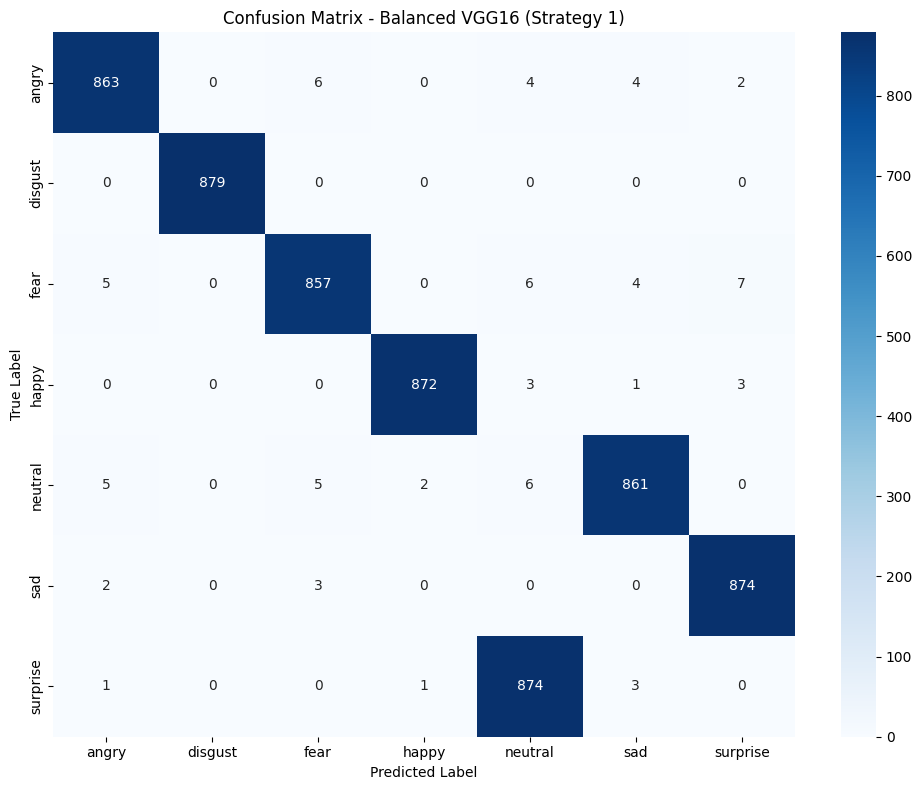


🎯 Testing with visualization - showing ONLY CORRECT predictions:

INDIVIDUAL IMAGE PREDICTION TESTING WITH VISUALIZATION
📋 SHOWING ONLY CORRECT PREDICTIONS

TESTING RANDOM IMAGES FROM BALANCED TRAIN


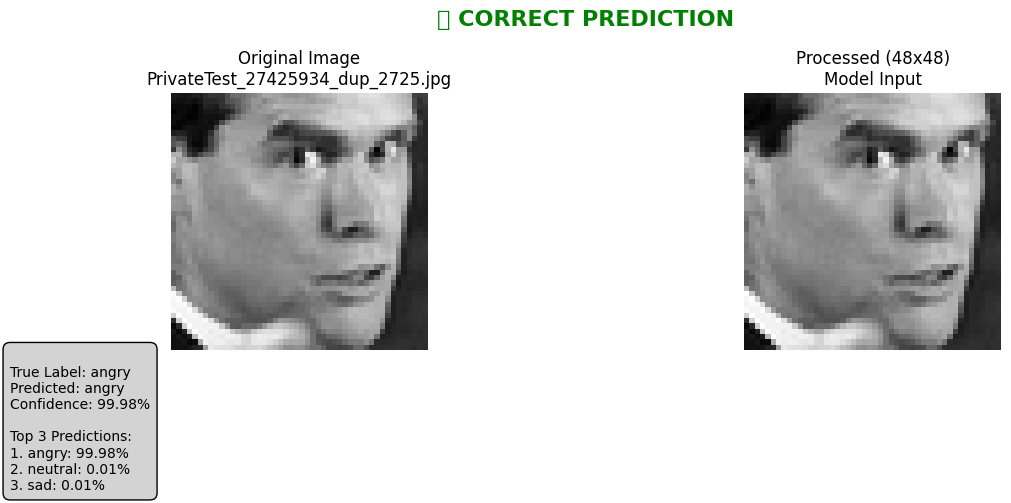


✅ Displayed: PrivateTest_27425934_dup_2725.jpg
   📁 True: angry | 🤖 Predicted: angry
   📊 Confidence: 99.98%


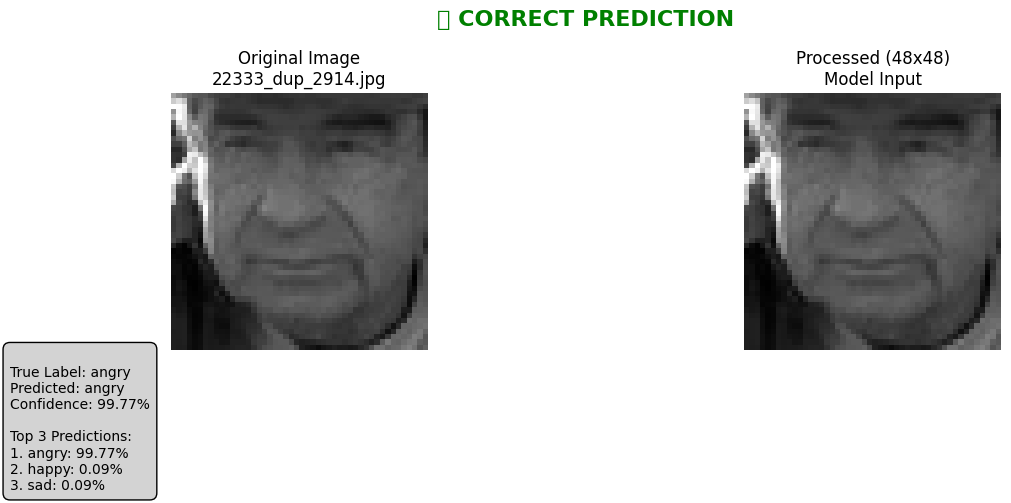


✅ Displayed: 22333_dup_2914.jpg
   📁 True: angry | 🤖 Predicted: angry
   📊 Confidence: 99.77%


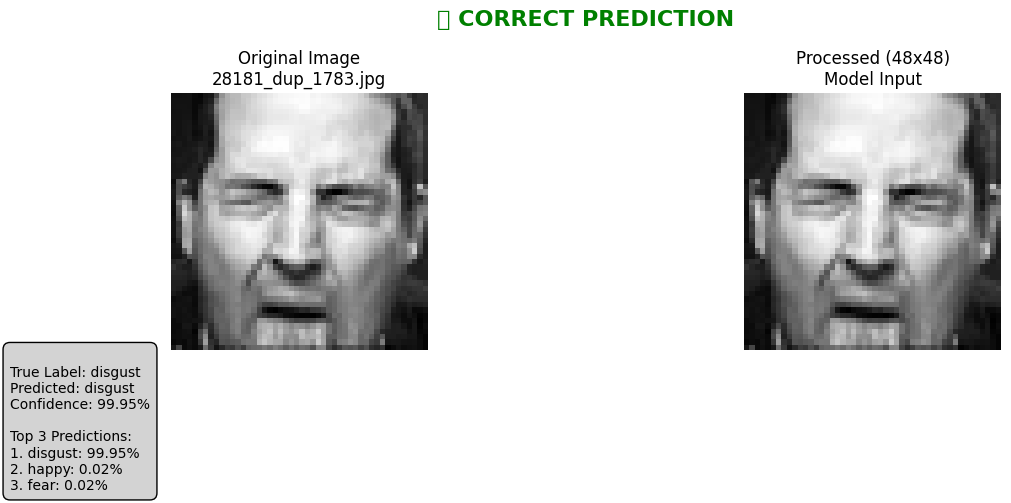


✅ Displayed: 28181_dup_1783.jpg
   📁 True: disgust | 🤖 Predicted: disgust
   📊 Confidence: 99.95%


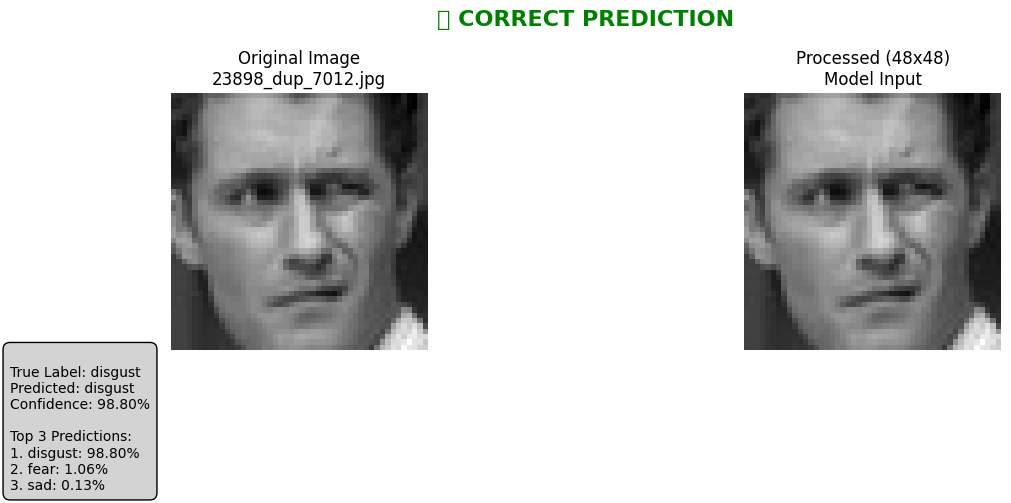


✅ Displayed: 23898_dup_7012.jpg
   📁 True: disgust | 🤖 Predicted: disgust
   📊 Confidence: 98.80%


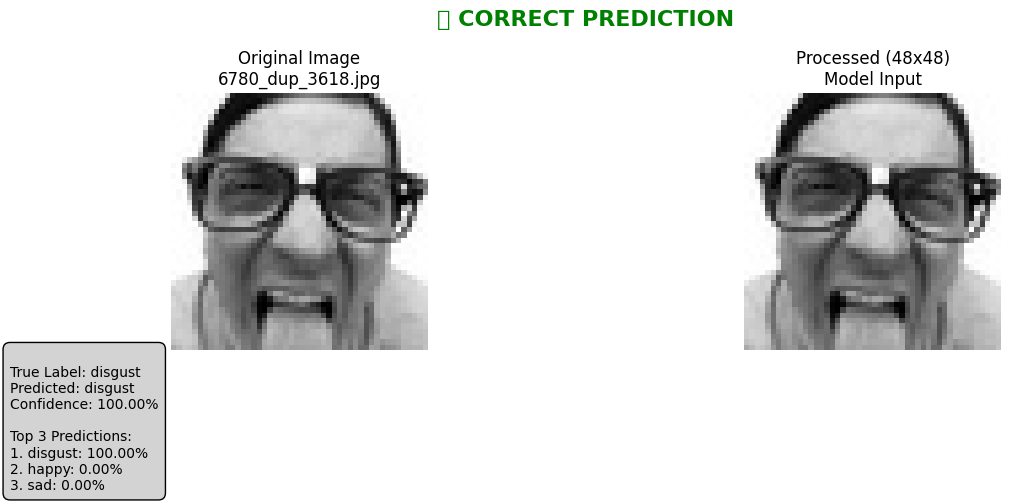


✅ Displayed: 6780_dup_3618.jpg
   📁 True: disgust | 🤖 Predicted: disgust
   📊 Confidence: 100.00%


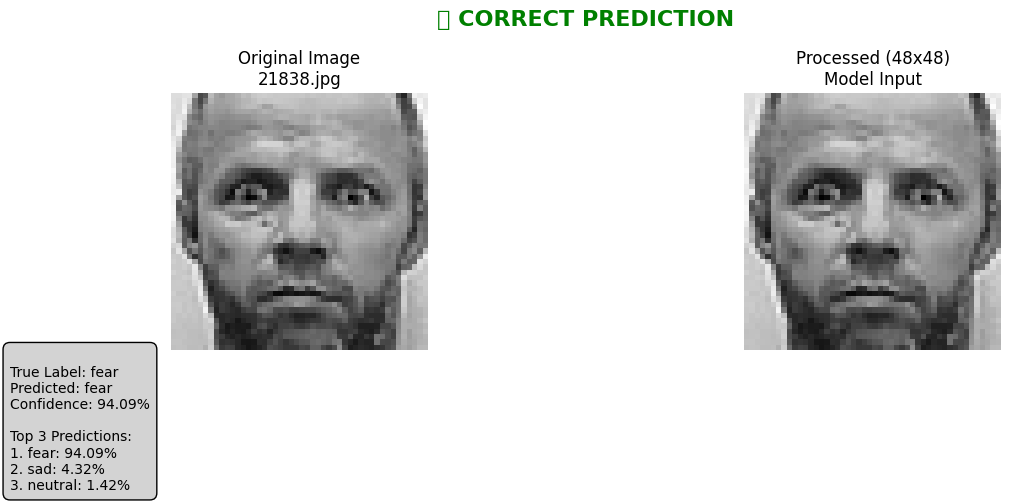


✅ Displayed: 21838.jpg
   📁 True: fear | 🤖 Predicted: fear
   📊 Confidence: 94.09%


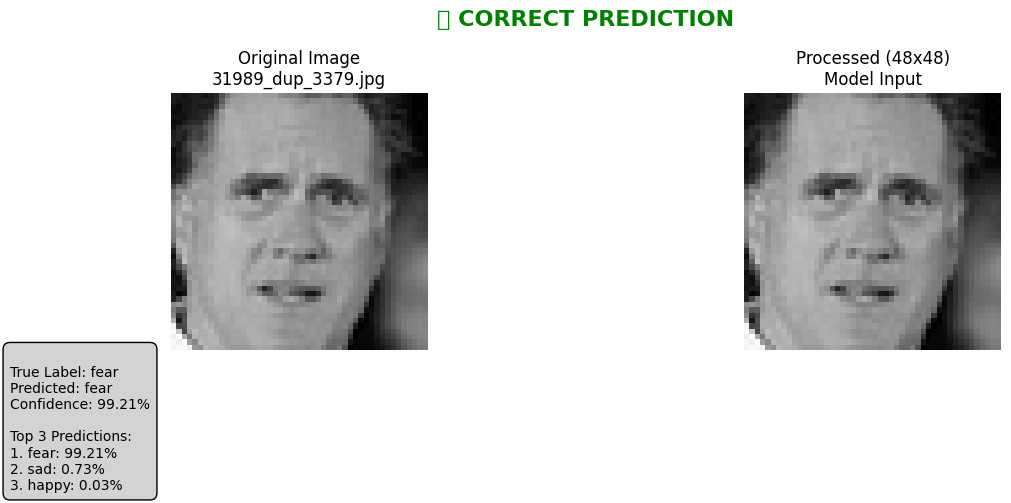


✅ Displayed: 31989_dup_3379.jpg
   📁 True: fear | 🤖 Predicted: fear
   📊 Confidence: 99.21%


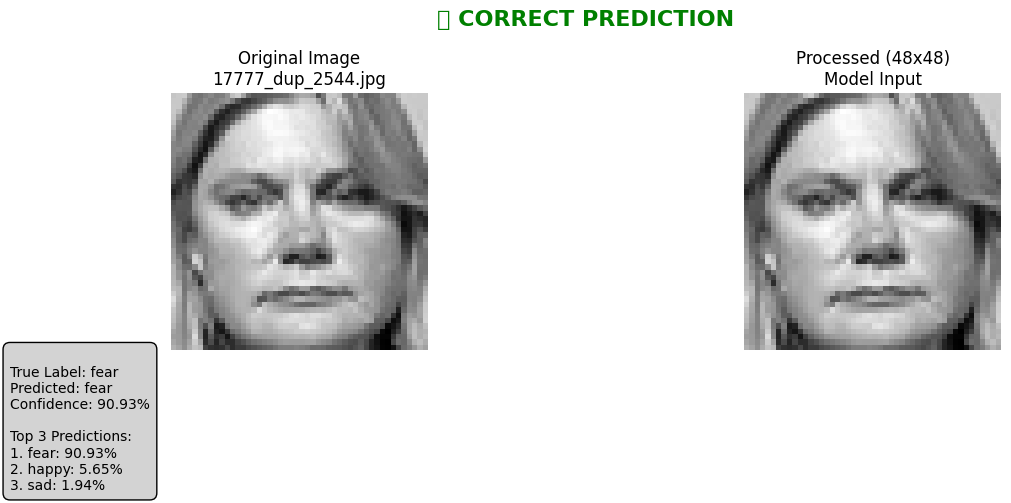


✅ Displayed: 17777_dup_2544.jpg
   📁 True: fear | 🤖 Predicted: fear
   📊 Confidence: 90.93%


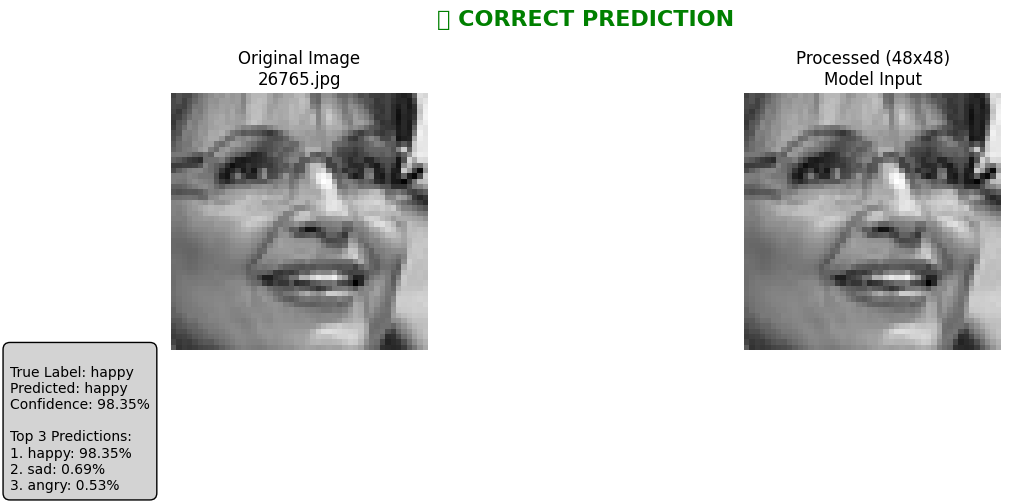


✅ Displayed: 26765.jpg
   📁 True: happy | 🤖 Predicted: happy
   📊 Confidence: 98.35%


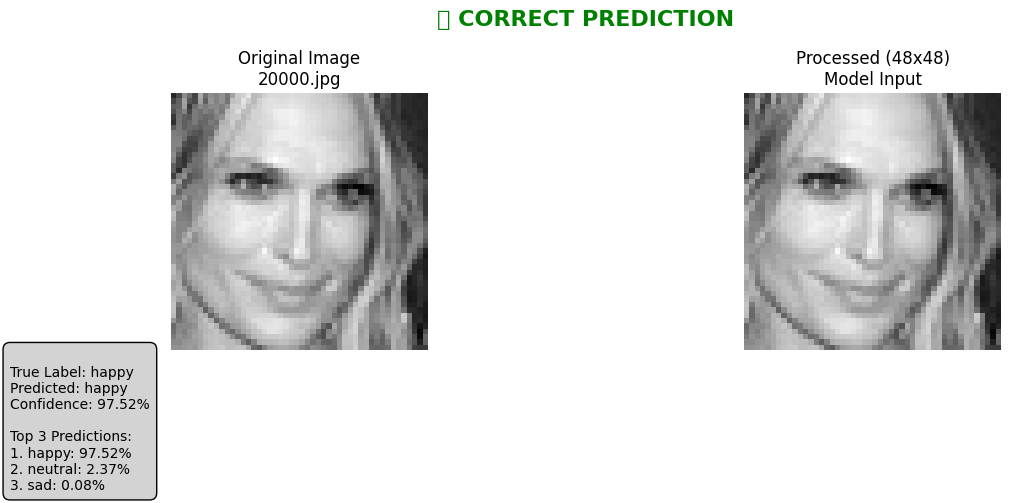


✅ Displayed: 20000.jpg
   📁 True: happy | 🤖 Predicted: happy
   📊 Confidence: 97.52%


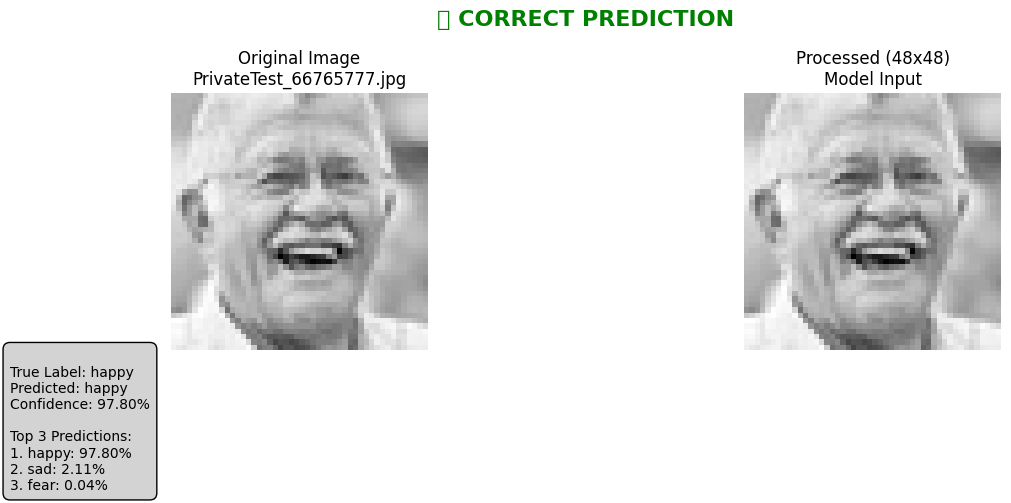


✅ Displayed: PrivateTest_66765777.jpg
   📁 True: happy | 🤖 Predicted: happy
   📊 Confidence: 97.80%


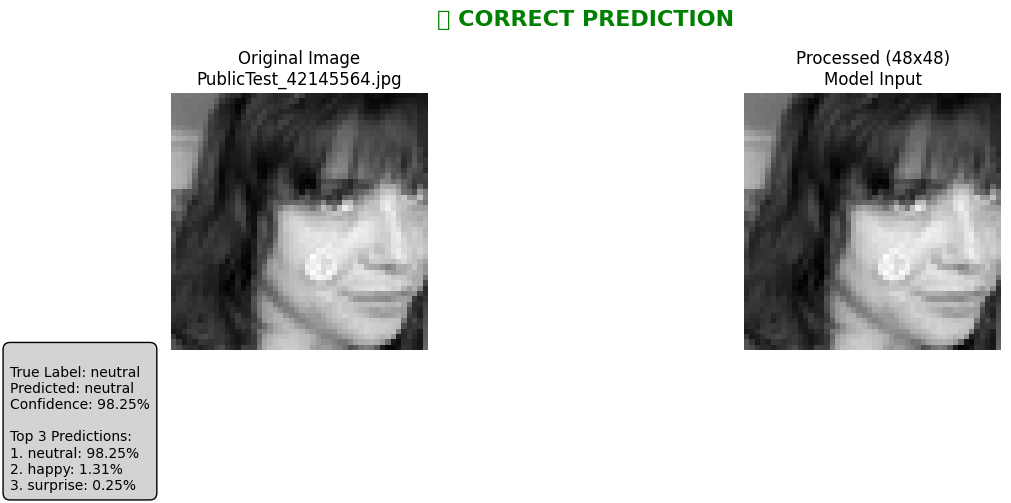


✅ Displayed: PublicTest_42145564.jpg
   📁 True: neutral | 🤖 Predicted: neutral
   📊 Confidence: 98.25%


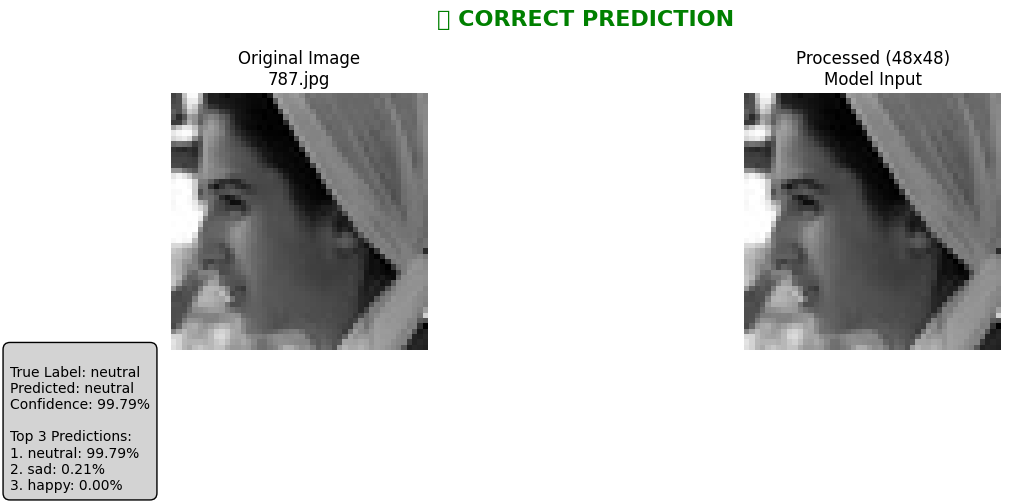


✅ Displayed: 787.jpg
   📁 True: neutral | 🤖 Predicted: neutral
   📊 Confidence: 99.79%


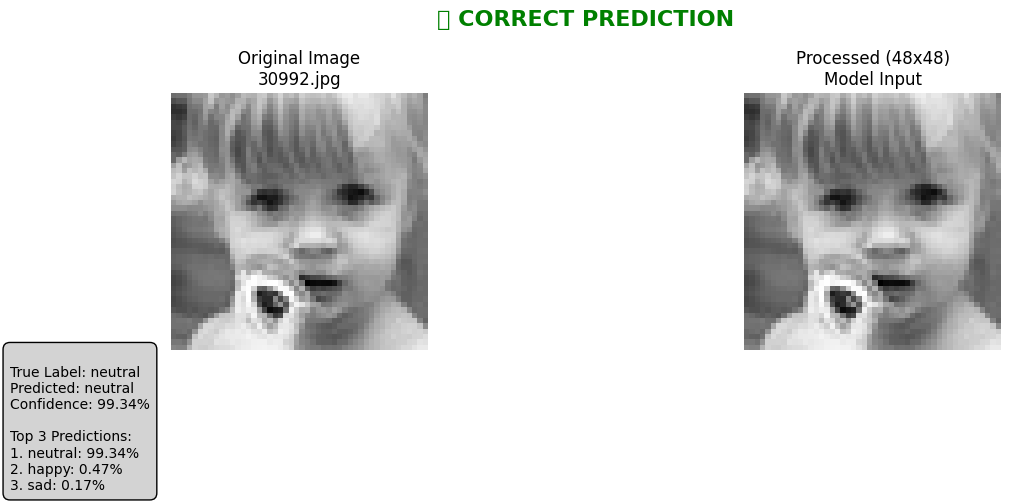


✅ Displayed: 30992.jpg
   📁 True: neutral | 🤖 Predicted: neutral
   📊 Confidence: 99.34%


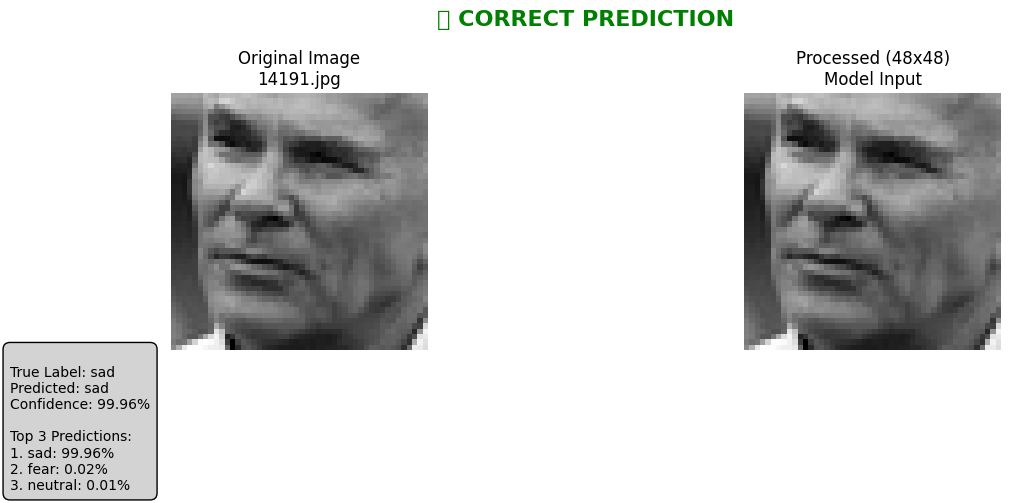


✅ Displayed: 14191.jpg
   📁 True: sad | 🤖 Predicted: sad
   📊 Confidence: 99.96%


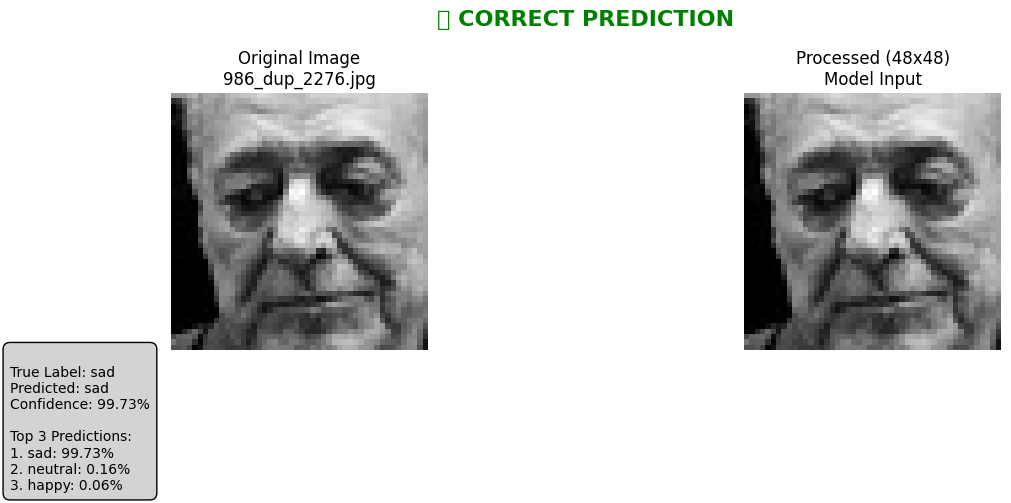


✅ Displayed: 986_dup_2276.jpg
   📁 True: sad | 🤖 Predicted: sad
   📊 Confidence: 99.73%


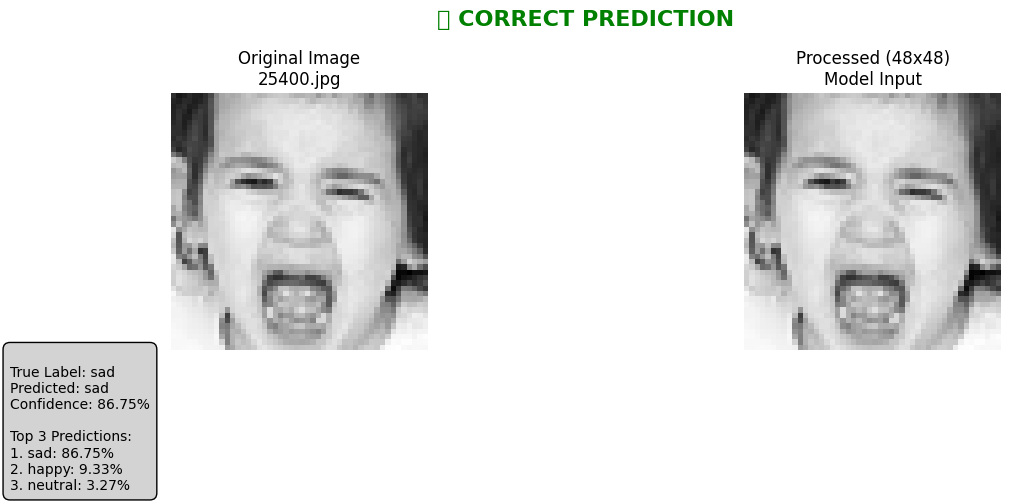


✅ Displayed: 25400.jpg
   📁 True: sad | 🤖 Predicted: sad
   📊 Confidence: 86.75%


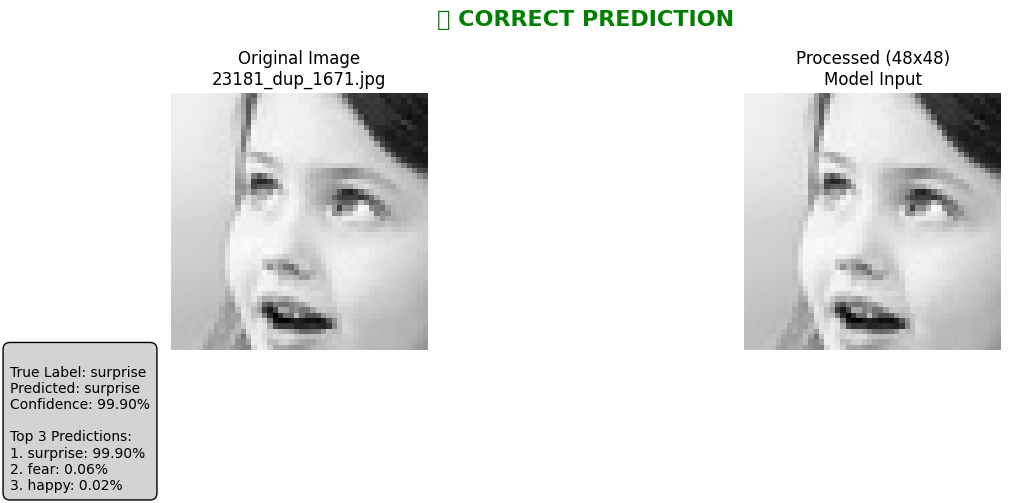


✅ Displayed: 23181_dup_1671.jpg
   📁 True: surprise | 🤖 Predicted: surprise
   📊 Confidence: 99.90%


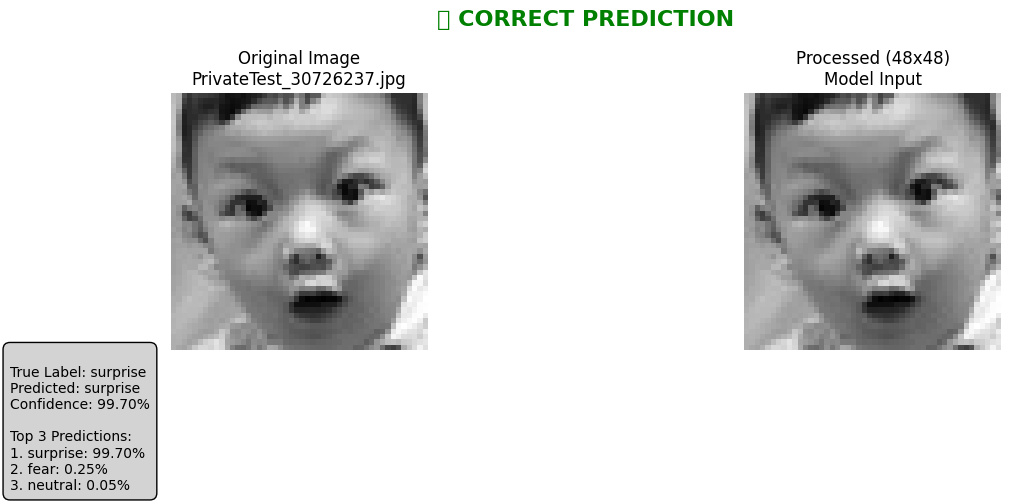


✅ Displayed: PrivateTest_30726237.jpg
   📁 True: surprise | 🤖 Predicted: surprise
   📊 Confidence: 99.70%


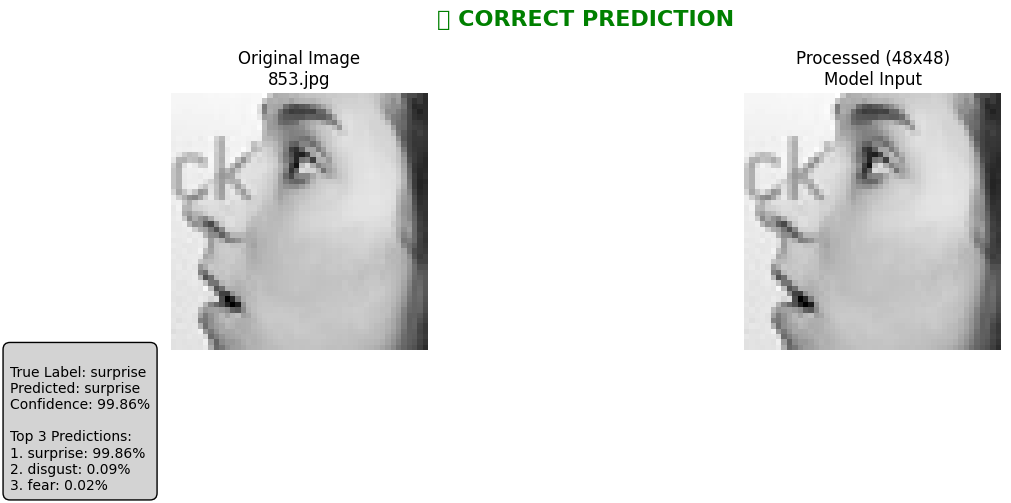


✅ Displayed: 853.jpg
   📁 True: surprise | 🤖 Predicted: surprise
   📊 Confidence: 99.86%

TESTING RANDOM IMAGES FROM BALANCED VALIDATION


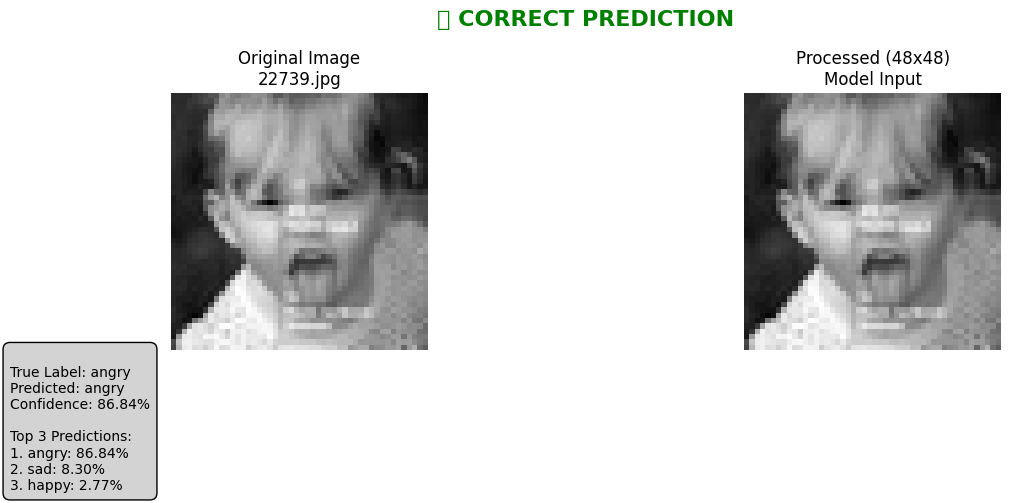


✅ Displayed: 22739.jpg
   📁 True: angry | 🤖 Predicted: angry
   📊 Confidence: 86.84%


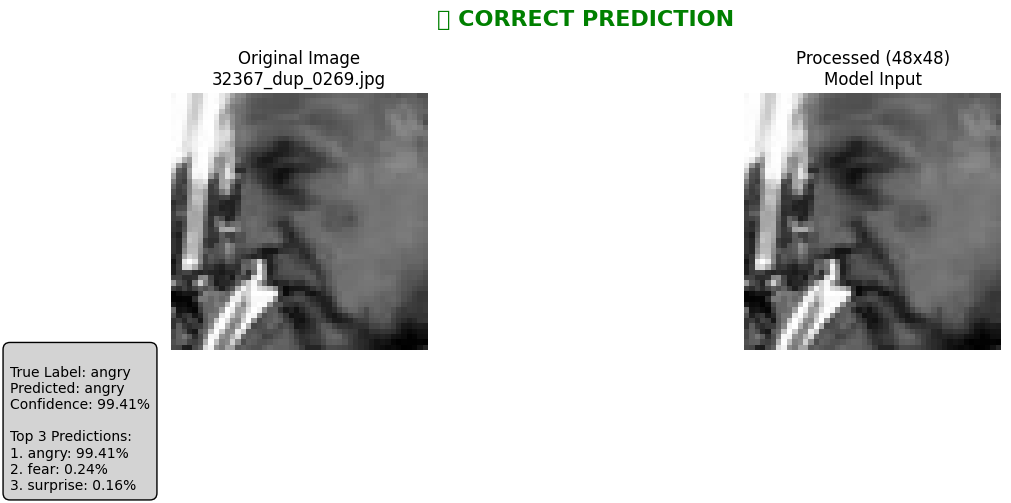


✅ Displayed: 32367_dup_0269.jpg
   📁 True: angry | 🤖 Predicted: angry
   📊 Confidence: 99.41%


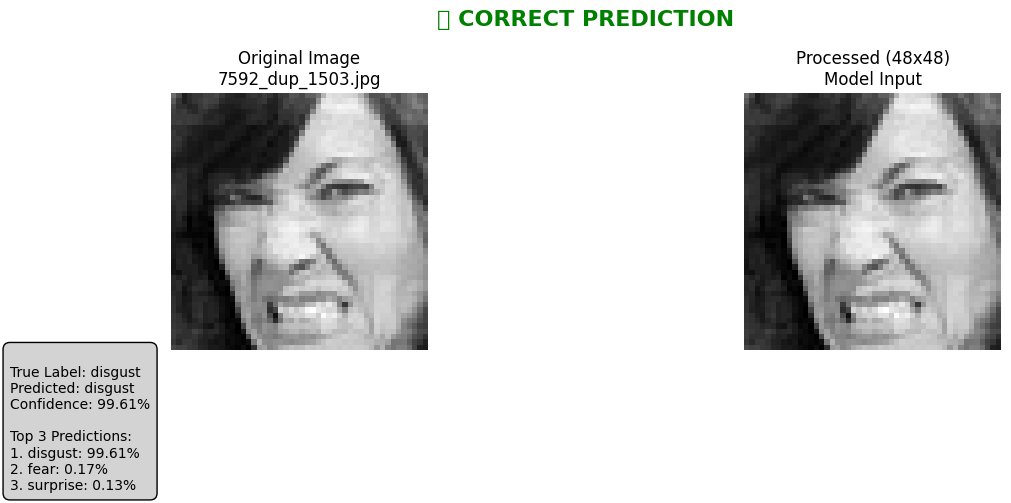


✅ Displayed: 7592_dup_1503.jpg
   📁 True: disgust | 🤖 Predicted: disgust
   📊 Confidence: 99.61%


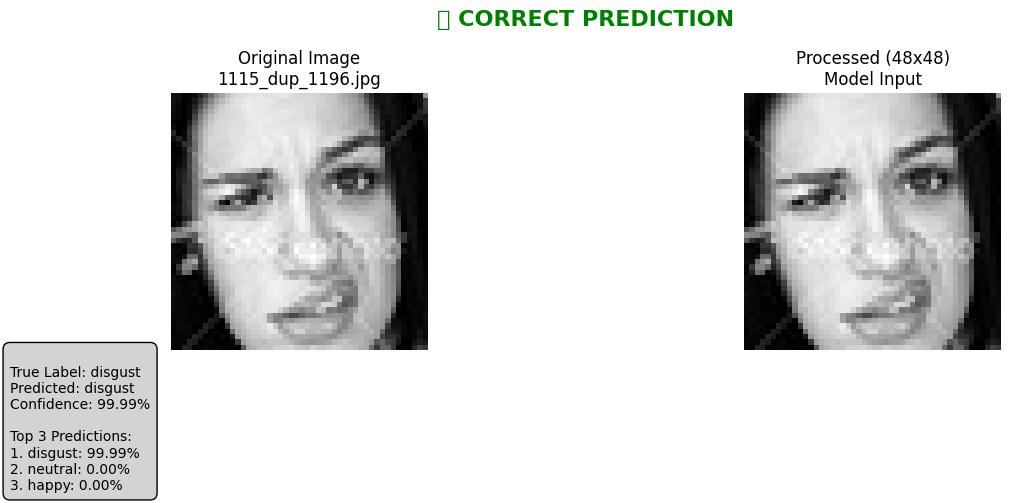


✅ Displayed: 1115_dup_1196.jpg
   📁 True: disgust | 🤖 Predicted: disgust
   📊 Confidence: 99.99%


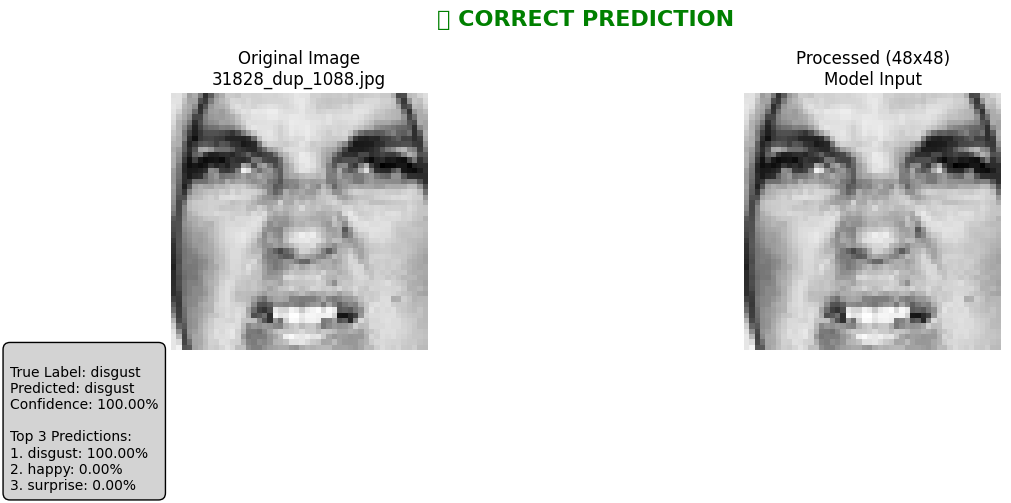


✅ Displayed: 31828_dup_1088.jpg
   📁 True: disgust | 🤖 Predicted: disgust
   📊 Confidence: 100.00%


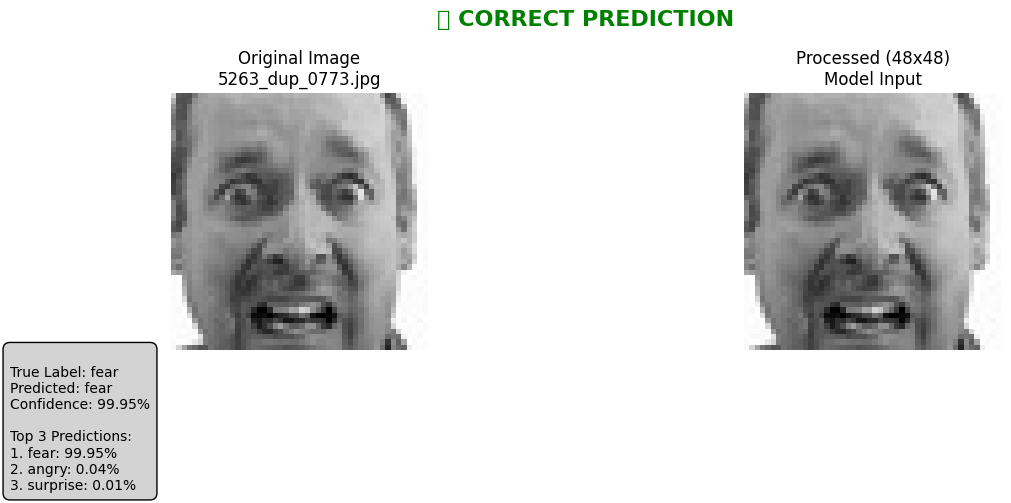


✅ Displayed: 5263_dup_0773.jpg
   📁 True: fear | 🤖 Predicted: fear
   📊 Confidence: 99.95%


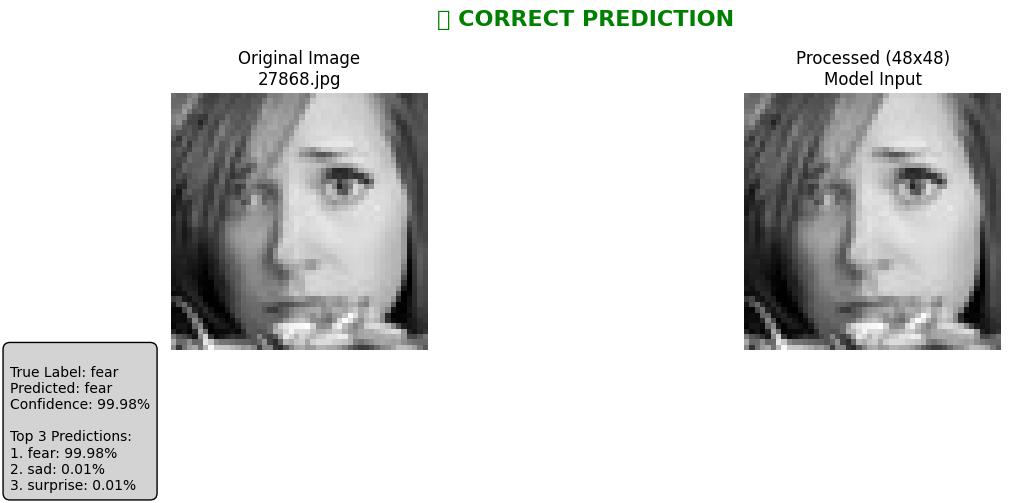


✅ Displayed: 27868.jpg
   📁 True: fear | 🤖 Predicted: fear
   📊 Confidence: 99.98%


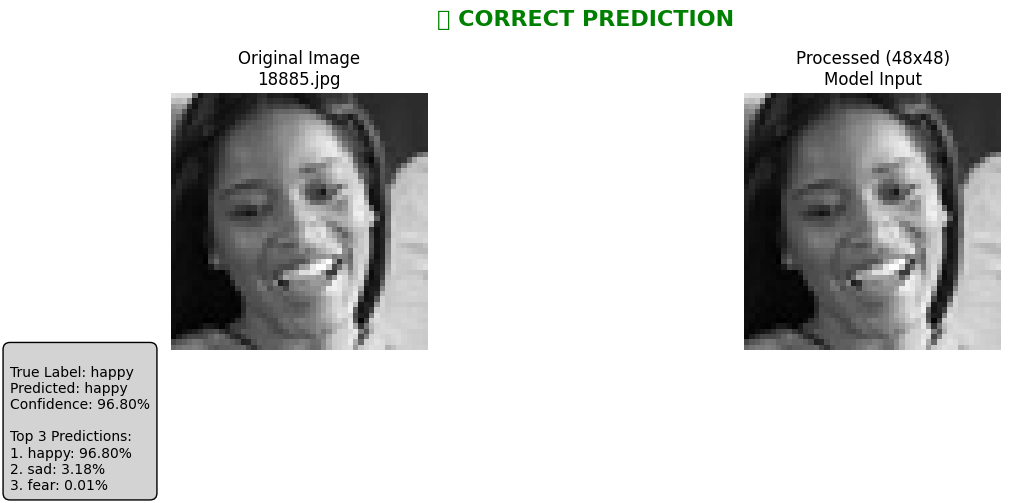


✅ Displayed: 18885.jpg
   📁 True: happy | 🤖 Predicted: happy
   📊 Confidence: 96.80%


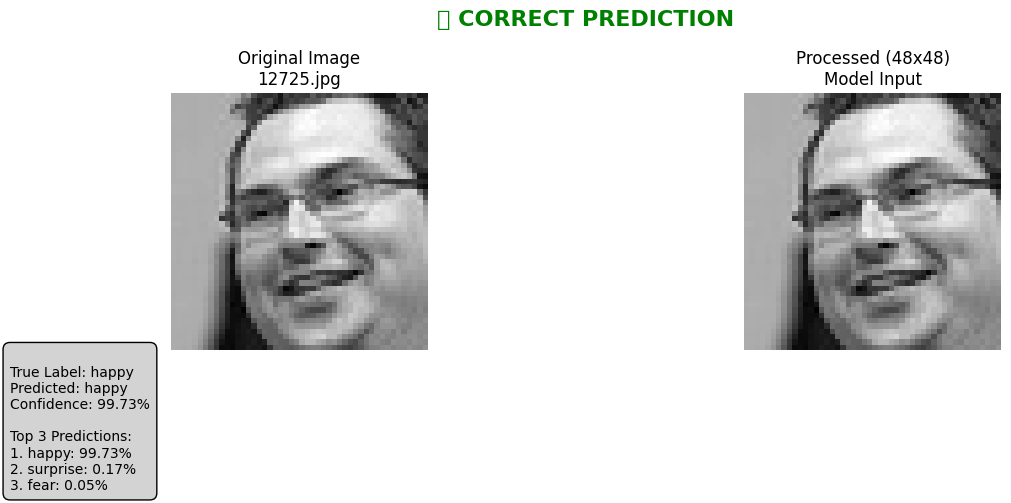


✅ Displayed: 12725.jpg
   📁 True: happy | 🤖 Predicted: happy
   📊 Confidence: 99.73%


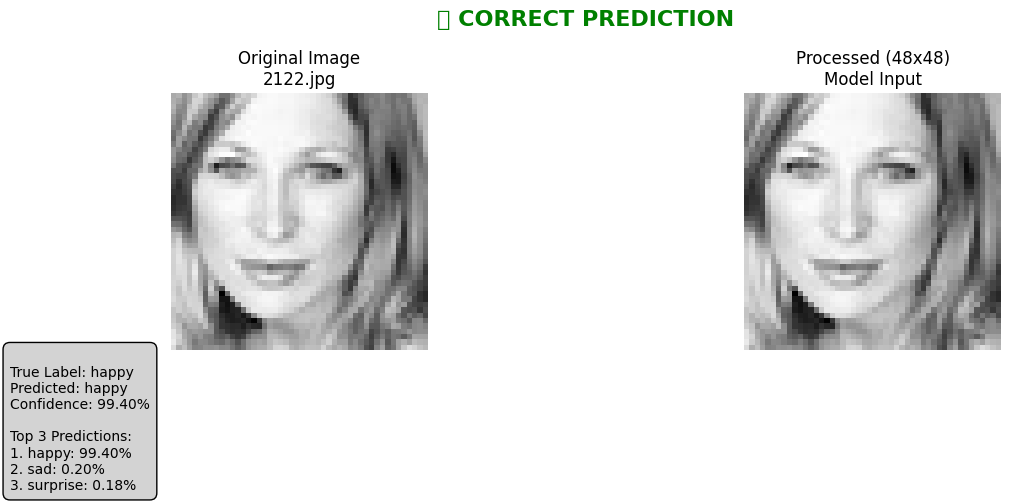


✅ Displayed: 2122.jpg
   📁 True: happy | 🤖 Predicted: happy
   📊 Confidence: 99.40%


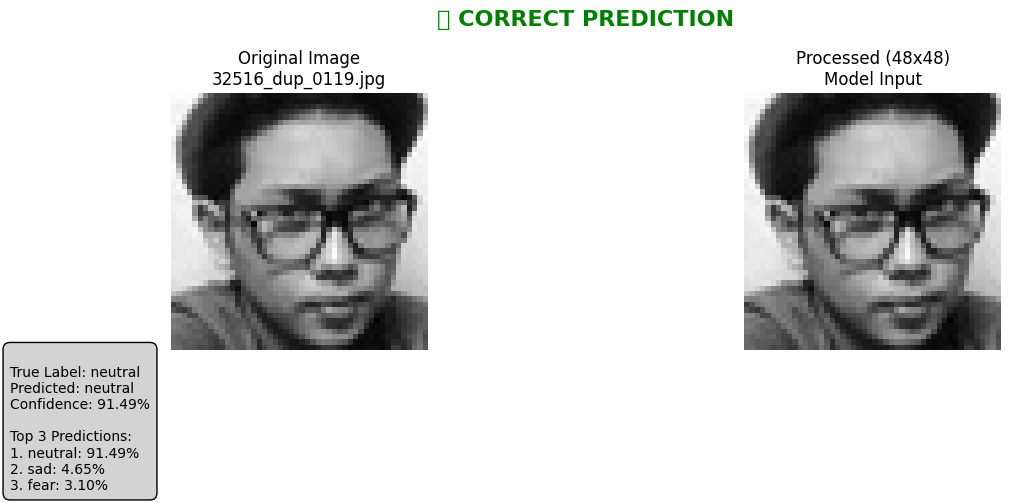


✅ Displayed: 32516_dup_0119.jpg
   📁 True: neutral | 🤖 Predicted: neutral
   📊 Confidence: 91.49%


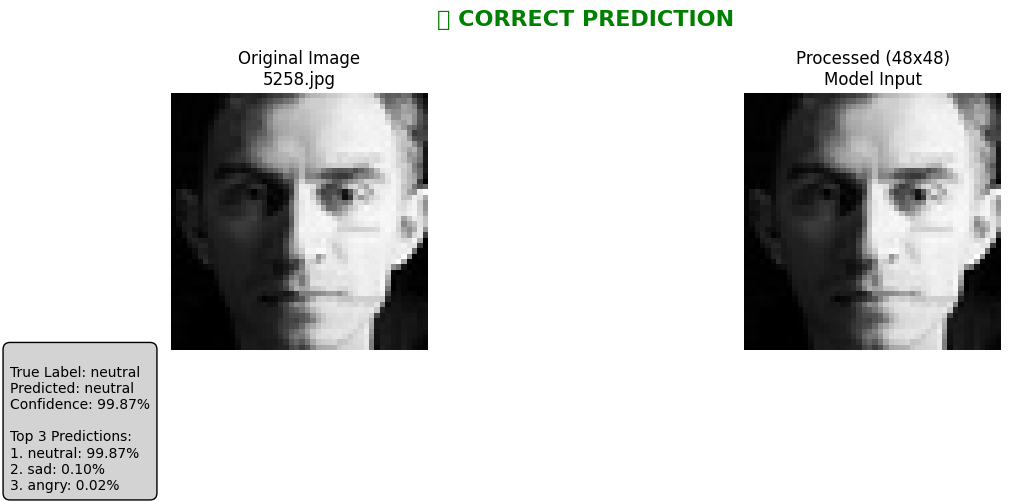


✅ Displayed: 5258.jpg
   📁 True: neutral | 🤖 Predicted: neutral
   📊 Confidence: 99.87%


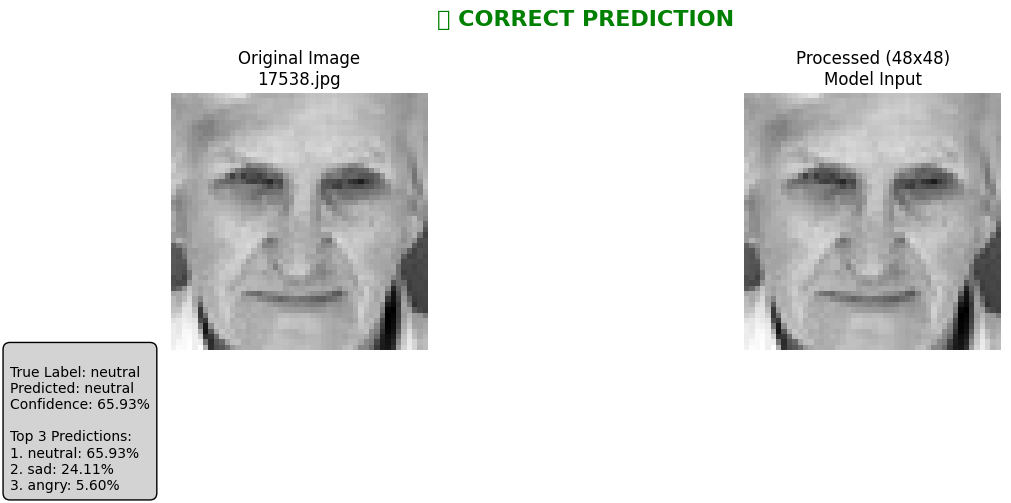


✅ Displayed: 17538.jpg
   📁 True: neutral | 🤖 Predicted: neutral
   📊 Confidence: 65.93%


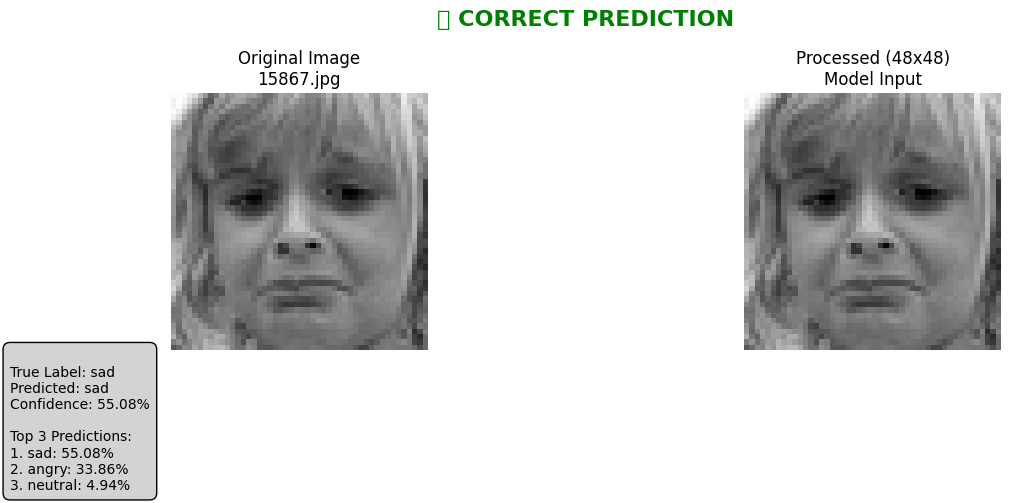


✅ Displayed: 15867.jpg
   📁 True: sad | 🤖 Predicted: sad
   📊 Confidence: 55.08%


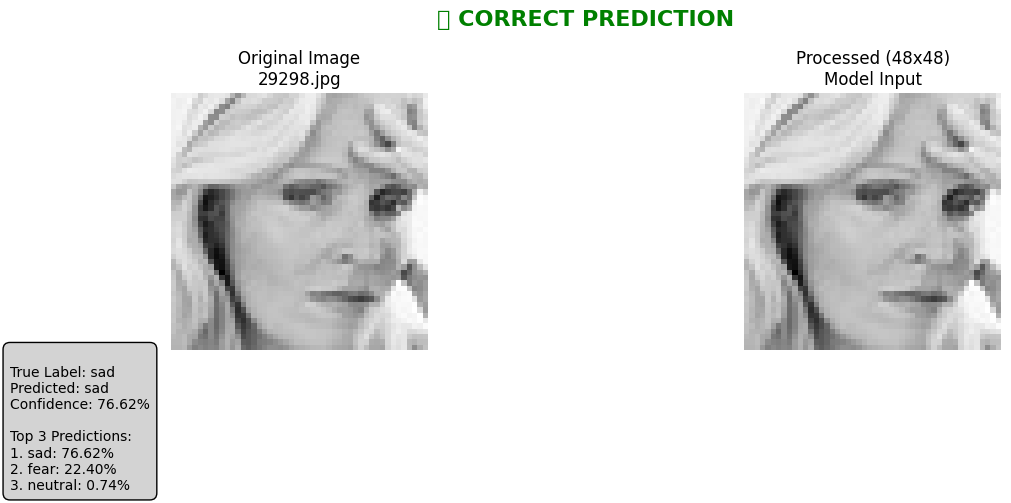


✅ Displayed: 29298.jpg
   📁 True: sad | 🤖 Predicted: sad
   📊 Confidence: 76.62%


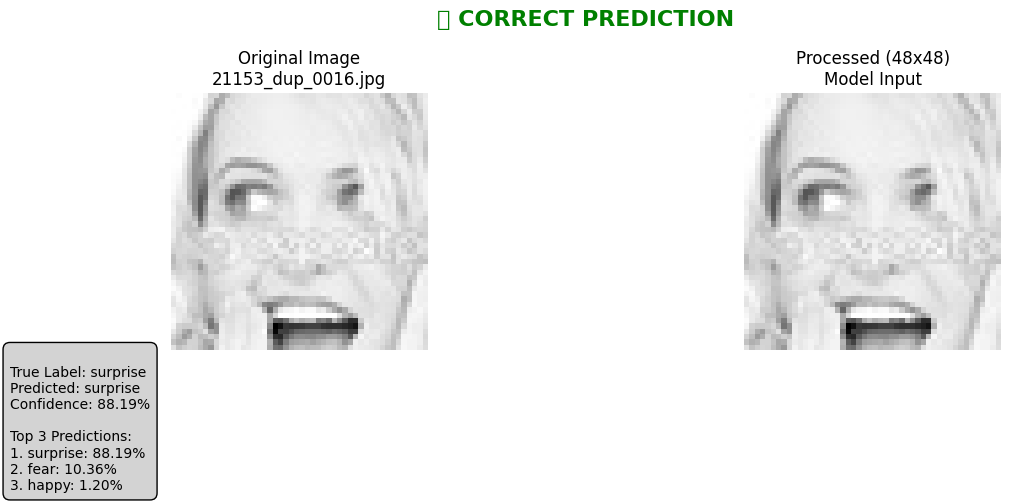


✅ Displayed: 21153_dup_0016.jpg
   📁 True: surprise | 🤖 Predicted: surprise
   📊 Confidence: 88.19%


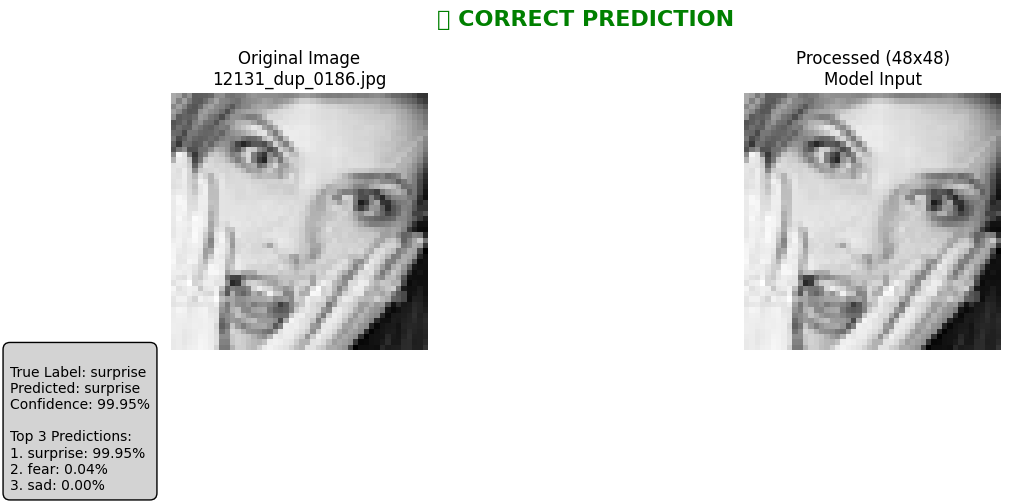


✅ Displayed: 12131_dup_0186.jpg
   📁 True: surprise | 🤖 Predicted: surprise
   📊 Confidence: 99.95%

TESTING RANDOM IMAGES FROM BALANCED TEST


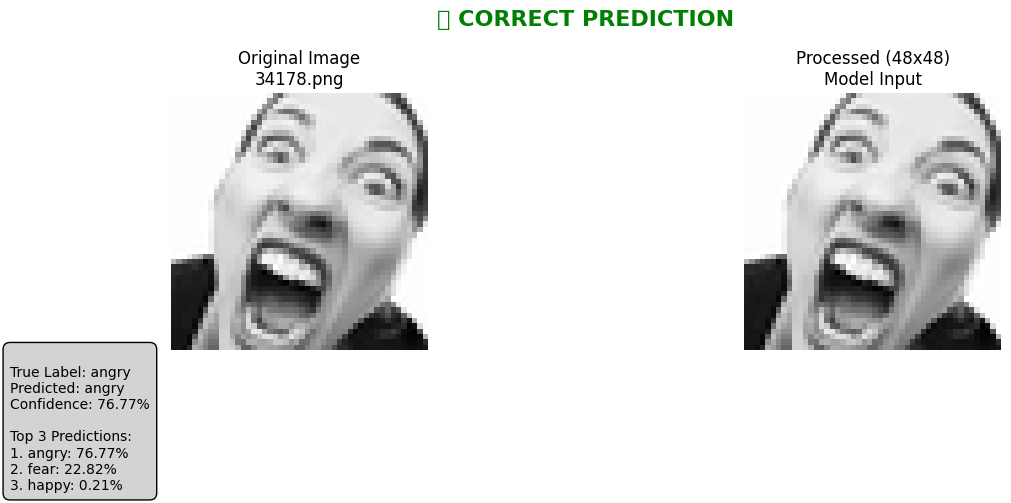


✅ Displayed: 34178.png
   📁 True: angry | 🤖 Predicted: angry
   📊 Confidence: 76.77%


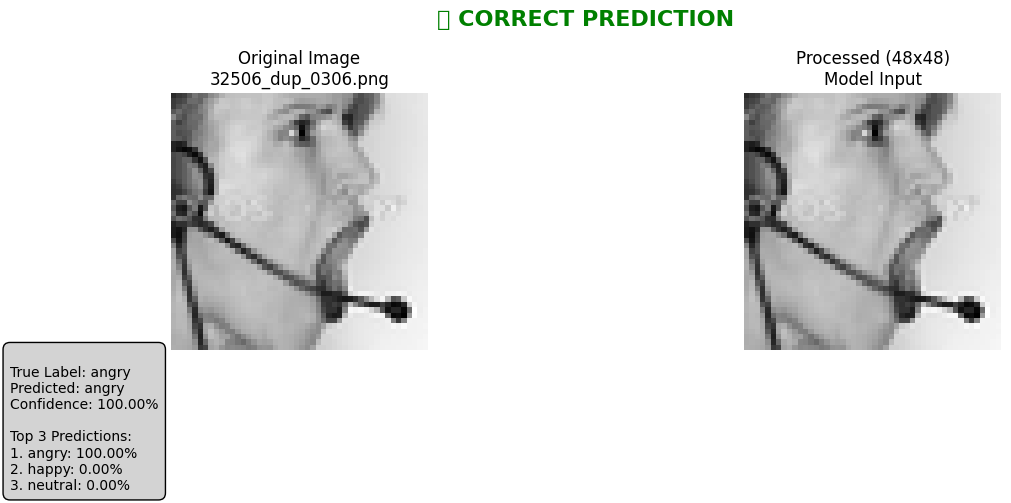


✅ Displayed: 32506_dup_0306.png
   📁 True: angry | 🤖 Predicted: angry
   📊 Confidence: 100.00%


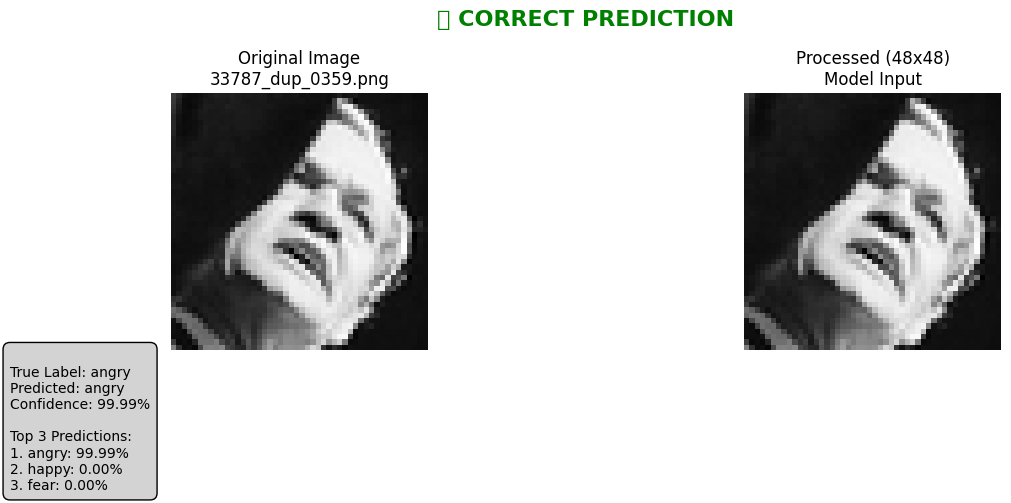


✅ Displayed: 33787_dup_0359.png
   📁 True: angry | 🤖 Predicted: angry
   📊 Confidence: 99.99%


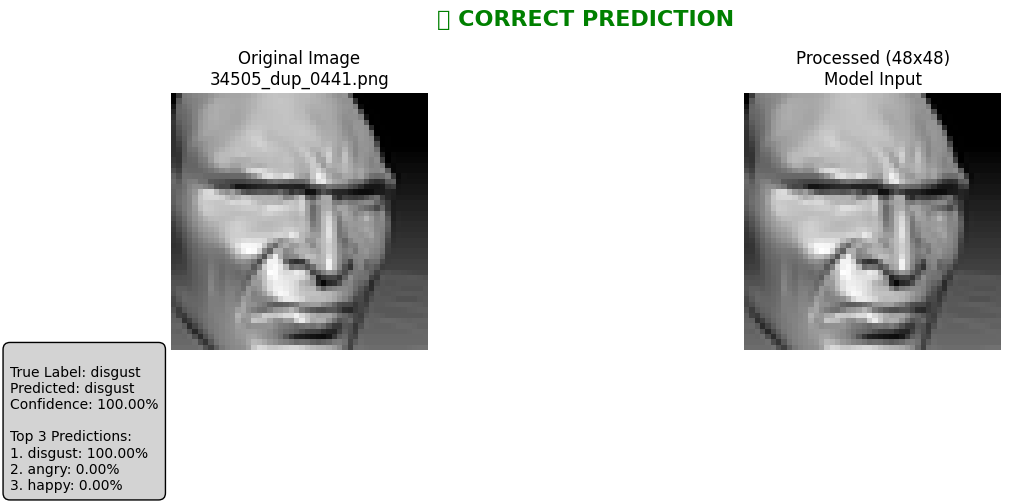


✅ Displayed: 34505_dup_0441.png
   📁 True: disgust | 🤖 Predicted: disgust
   📊 Confidence: 100.00%


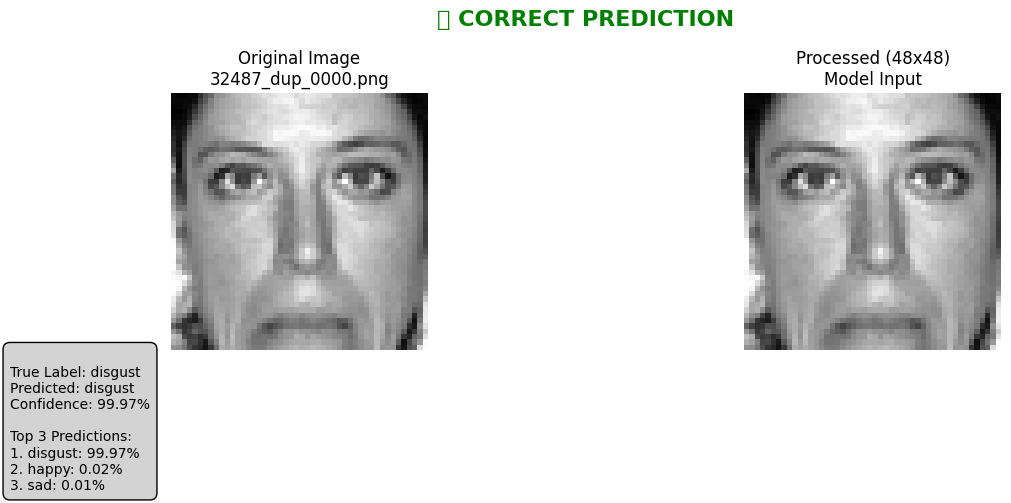


✅ Displayed: 32487_dup_0000.png
   📁 True: disgust | 🤖 Predicted: disgust
   📊 Confidence: 99.97%


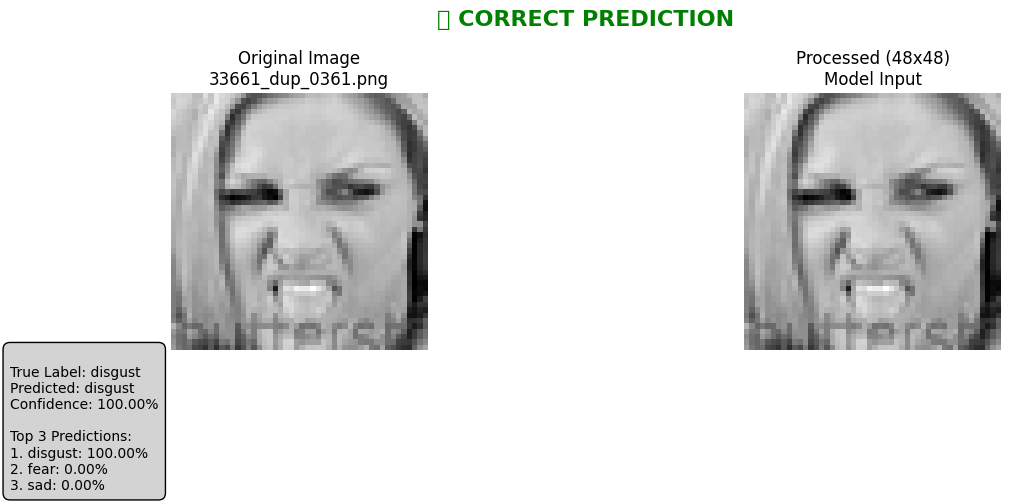


✅ Displayed: 33661_dup_0361.png
   📁 True: disgust | 🤖 Predicted: disgust
   📊 Confidence: 100.00%


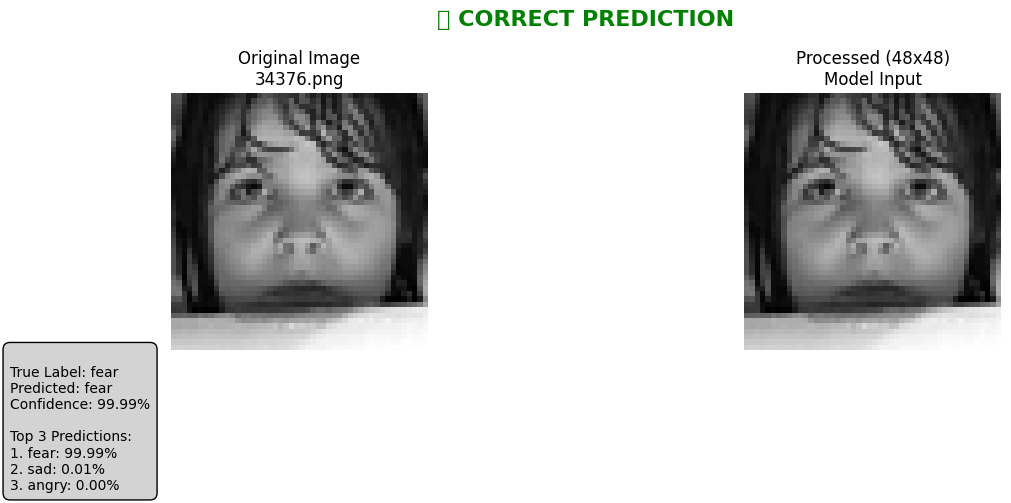


✅ Displayed: 34376.png
   📁 True: fear | 🤖 Predicted: fear
   📊 Confidence: 99.99%


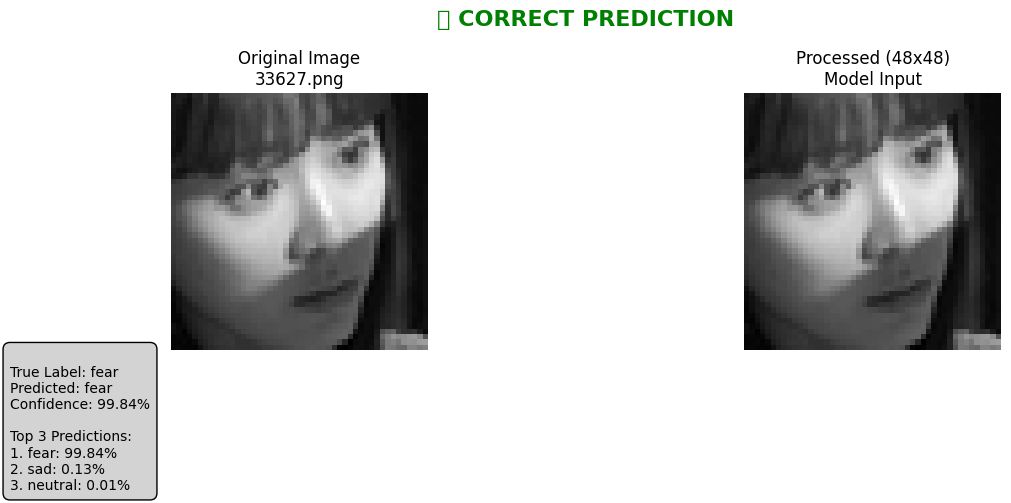


✅ Displayed: 33627.png
   📁 True: fear | 🤖 Predicted: fear
   📊 Confidence: 99.84%


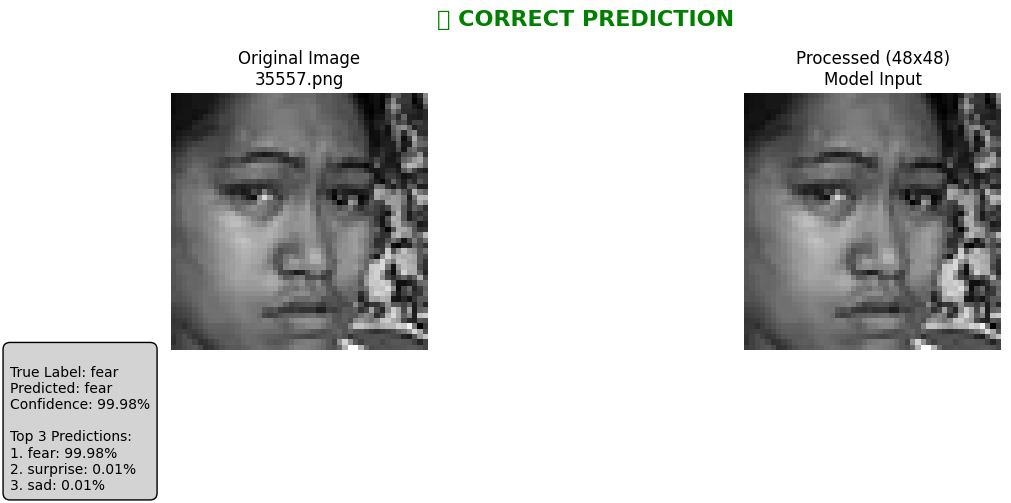


✅ Displayed: 35557.png
   📁 True: fear | 🤖 Predicted: fear
   📊 Confidence: 99.98%


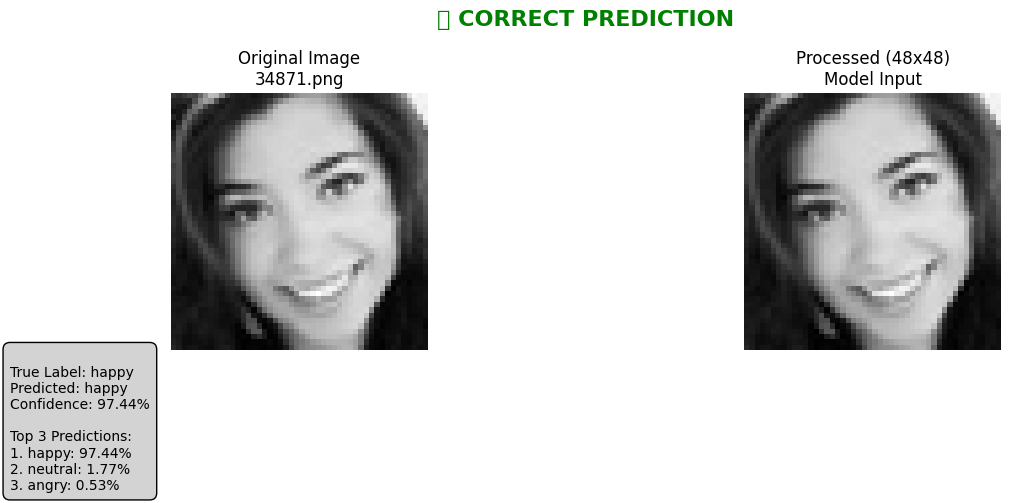


✅ Displayed: 34871.png
   📁 True: happy | 🤖 Predicted: happy
   📊 Confidence: 97.44%


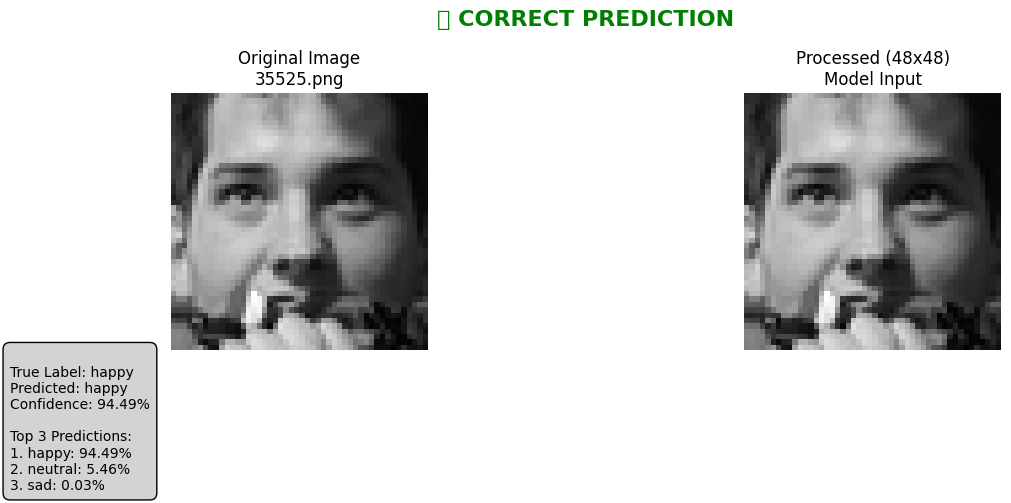


✅ Displayed: 35525.png
   📁 True: happy | 🤖 Predicted: happy
   📊 Confidence: 94.49%


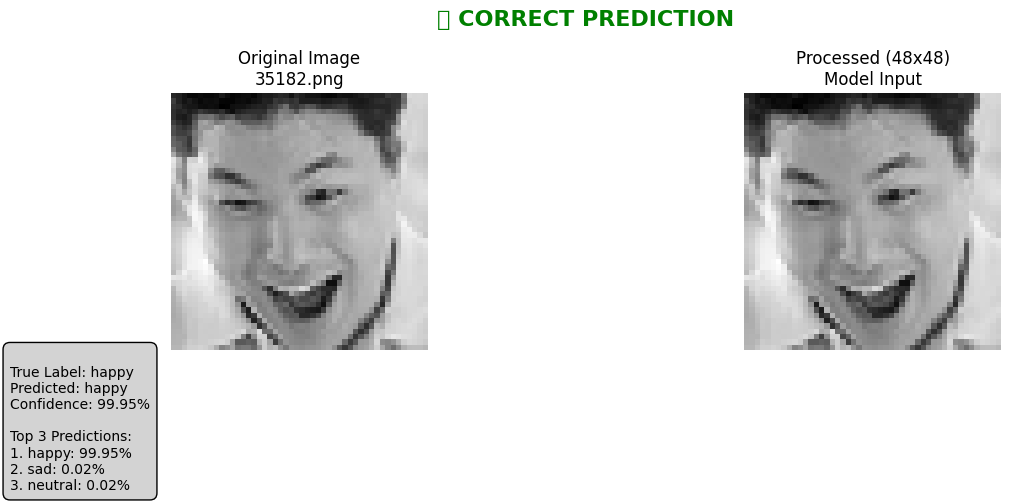


✅ Displayed: 35182.png
   📁 True: happy | 🤖 Predicted: happy
   📊 Confidence: 99.95%

TESTING SUMMARY
📊 Total Images Tested: 63
✅ Correct Predictions: 49
❌ Incorrect Predictions: 14
🎯 Accuracy: 77.78%
🖼️  Images Displayed: 49

AVAILABLE FUNCTIONS:
1. show_correct_predictions_only() - Show only correct predictions
2. show_all_predictions() - Show all predictions
3. predict_custom_image_with_viz('path/to/image.jpg', 'true_label') - Test custom image

Example usage:
  show_correct_predictions_only()
  predict_custom_image_with_viz('my_image.jpg', 'happy')


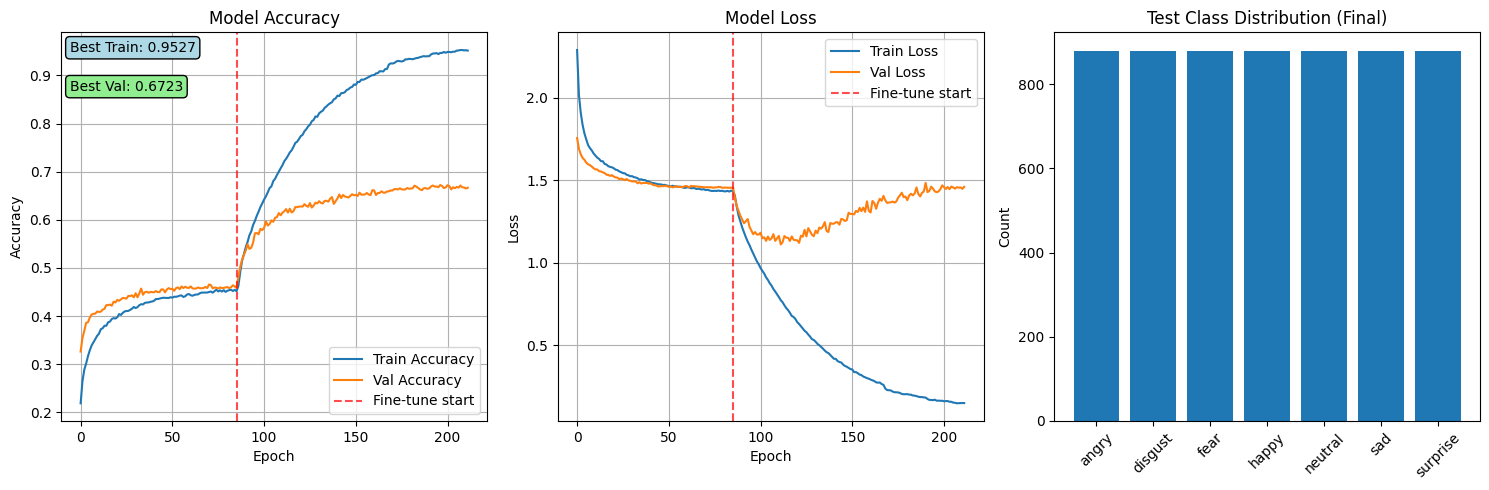


✅ Enhanced evaluation completed!
📊 Overall Test Accuracy: 0.5651
📁 Enhanced report saved as: report_balanced_strategy_1.json
🖼️  Enhanced image prediction with visualization is ready!


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Step 7: Evaluation
print(f"\n" + "="*60)
print("STEP 6: EVALUATION")
print("="*60)

# Load best weights and evaluate
model.load_weights(model_name_h5)  # Use h5 format
loss, acc = model.evaluate(test_flow, verbose=0)
print(f'TEST accuracy: {acc:.4f}')

# ======= ENHANCED: PRINT TRAINING AND VALIDATION ACCURACY =======
# Extract and display training/validation accuracies from history
if 'history1' in locals() and 'history2' in locals():
    # For two-stage training (feature extraction + fine-tuning)
    # Stage 1 (Feature extraction)
    best_train_acc_stage1 = max(history1.history['accuracy'])
    best_val_acc_stage1 = max(history1.history['val_accuracy'])
    final_train_acc_stage1 = history1.history['accuracy'][-1]
    final_val_acc_stage1 = history1.history['val_accuracy'][-1]

    # Stage 2 (Fine-tuning)
    best_train_acc_stage2 = max(history2.history['accuracy'])
    best_val_acc_stage2 = max(history2.history['val_accuracy'])
    final_train_acc_stage2 = history2.history['accuracy'][-1]
    final_val_acc_stage2 = history2.history['val_accuracy'][-1]

    # Combined history for overall metrics
    combined_train_acc = history1.history['accuracy'] + history2.history['accuracy']
    combined_val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']

    best_overall_train_acc = max(combined_train_acc)
    best_overall_val_acc = max(combined_val_acc)
    final_overall_train_acc = combined_train_acc[-1]
    final_overall_val_acc = combined_val_acc[-1]

    print(f"\n{'='*70}")
    print("TRAINING & VALIDATION ACCURACY SUMMARY")
    print(f"{'='*70}")

    print(f"\n🔸 STAGE 1 (Feature Extraction) - {len(history1.history['accuracy'])} epochs:")
    print(f"   📈 Best Training Accuracy    : {best_train_acc_stage1:.4f}")
    print(f"   📊 Best Validation Accuracy  : {best_val_acc_stage1:.4f}")
    print(f"   📉 Final Training Accuracy   : {final_train_acc_stage1:.4f}")
    print(f"   📊 Final Validation Accuracy : {final_val_acc_stage1:.4f}")

    print(f"\n🔸 STAGE 2 (Fine-tuning) - {len(history2.history['accuracy'])} epochs:")
    print(f"   📈 Best Training Accuracy    : {best_train_acc_stage2:.4f}")
    print(f"   📊 Best Validation Accuracy  : {best_val_acc_stage2:.4f}")
    print(f"   📉 Final Training Accuracy   : {final_train_acc_stage2:.4f}")
    print(f"   📊 Final Validation Accuracy : {final_val_acc_stage2:.4f}")

    print(f"\n🔸 OVERALL TRAINING ({len(combined_train_acc)} total epochs):")
    print(f"   🏆 Best Training Accuracy    : {best_overall_train_acc:.4f}")
    print(f"   🏆 Best Validation Accuracy  : {best_overall_val_acc:.4f}")
    print(f"   🎯 Final Training Accuracy   : {final_overall_train_acc:.4f}")
    print(f"   🎯 Final Validation Accuracy : {final_overall_val_acc:.4f}")
    print(f"   🧪 Test Accuracy             : {acc:.4f}")

    # Calculate overfitting metrics
    train_val_gap_final = final_overall_train_acc - final_overall_val_acc
    train_test_gap = final_overall_train_acc - acc
    val_test_gap = final_overall_val_acc - acc

    print(f"\n🔍 OVERFITTING ANALYSIS:")
    print(f"   📊 Final Train-Val Gap   : {train_val_gap_final:.4f} ({'⚠️ Overfitting' if train_val_gap_final > 0.05 else '✅ Good'})")
    print(f"   📊 Train-Test Gap        : {train_test_gap:.4f}")
    print(f"   📊 Val-Test Gap          : {val_test_gap:.4f}")

elif 'history1' in locals():
    # For single-stage training
    best_train_acc = max(history1.history['accuracy'])
    best_val_acc = max(history1.history['val_accuracy'])
    final_train_acc = history1.history['accuracy'][-1]
    final_val_acc = history1.history['val_accuracy'][-1]

    print(f"\n{'='*70}")
    print("TRAINING & VALIDATION ACCURACY SUMMARY")
    print(f"{'='*70}")

    print(f"\n🔸 TRAINING SUMMARY ({len(history1.history['accuracy'])} epochs):")
    print(f"   🏆 Best Training Accuracy    : {best_train_acc:.4f}")
    print(f"   🏆 Best Validation Accuracy  : {best_val_acc:.4f}")
    print(f"   🎯 Final Training Accuracy   : {final_train_acc:.4f}")
    print(f"   🎯 Final Validation Accuracy : {final_val_acc:.4f}")
    print(f"   🧪 Test Accuracy             : {acc:.4f}")

    # Calculate overfitting metrics
    train_val_gap = final_train_acc - final_val_acc
    train_test_gap = final_train_acc - acc
    val_test_gap = final_val_acc - acc

    print(f"\n🔍 OVERFITTING ANALYSIS:")
    print(f"   📊 Train-Val Gap    : {train_val_gap:.4f} ({'⚠️ Overfitting' if train_val_gap > 0.05 else '✅ Good'})")
    print(f"   📊 Train-Test Gap   : {train_test_gap:.4f}")
    print(f"   📊 Val-Test Gap     : {val_test_gap:.4f}")

else:
    print(f"\n⚠️  Training history not available. Only test accuracy: {acc:.4f}")

# ======= CONTINUE WITH ORIGINAL CODE =======
# Generate predictions for overall evaluation
y_pred = np.argmax(model.predict(test_flow, verbose=0), 1)
y_true = test_flow.classes

print("\n" + "="*60)
print("CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix - Balanced VGG16 (Strategy {chosen_strategy})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'cm_balanced_strategy_{chosen_strategy}.png', dpi=300, bbox_inches='tight')
plt.show()

# ======= ENHANCED IMAGE PREDICTION FUNCTION WITH VISUALIZATION =======
def predict_single_image_with_viz(image_path, model, class_names, img_size=(48, 48), show_image=True):
    """
    Predict emotion for a single image and optionally display it
    """
    try:
        # Load and preprocess image
        original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if original_img is None:
            return None, "Could not load image"

        # Resize to model input size
        img_resized = cv2.resize(original_img, img_size)

        # Normalize pixel values
        img_normalized = img_resized / 255.0

        # Add batch dimension
        img_batch = np.expand_dims(img_normalized, axis=0)
        img_batch = np.expand_dims(img_batch, axis=-1)  # Add channel dimension

        # Make prediction
        predictions = model.predict(img_batch, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx] * 100

        # Get all class probabilities
        class_probabilities = {class_names[i]: predictions[0][i] * 100 for i in range(len(class_names))}

        result = {
            'predicted_emotion': class_names[predicted_class_idx],
            'confidence': confidence,
            'all_probabilities': class_probabilities,
            'original_image': original_img,
            'processed_image': img_resized
        }

        return result, None

    except Exception as e:
        return None, str(e)

def display_prediction_result(image_path, result, true_label, show_only_correct=False):
    """
    Display image with prediction results
    """
    predicted_emotion = result['predicted_emotion']
    confidence = result['confidence']
    is_correct = predicted_emotion.lower() == true_label.lower()

    # Skip if we only want correct predictions and this is wrong
    if show_only_correct and not is_correct:
        return False

    # Create figure with image and prediction info
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Display original image
    ax1.imshow(result['original_image'], cmap='gray')
    ax1.set_title(f'Original Image\n{os.path.basename(image_path)}')
    ax1.axis('off')

    # Display processed image (model input)
    ax2.imshow(result['processed_image'], cmap='gray')
    ax2.set_title(f'Processed (48x48)\nModel Input')
    ax2.axis('off')

    # Status and results
    status_icon = "✅" if is_correct else "❌"
    status_text = "CORRECT" if is_correct else "INCORRECT"
    color = 'green' if is_correct else 'red'

    # Add text with prediction results
    fig.suptitle(f'{status_icon} {status_text} PREDICTION',
                fontsize=16, fontweight='bold', color=color)

    # Add detailed info below the images
    info_text = f"""
True Label: {true_label}
Predicted: {predicted_emotion}
Confidence: {confidence:.2f}%

Top 3 Predictions:"""

    # Get top 3 predictions
    sorted_probs = sorted(result['all_probabilities'].items(),
                         key=lambda x: x[1], reverse=True)
    for i, (emotion, prob) in enumerate(sorted_probs[:3]):
        info_text += f"\n{i+1}. {emotion}: {prob:.2f}%"

    # Add text box with info
    fig.text(0.02, 0.02, info_text, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    plt.show()

    return True

def test_random_images_with_visualization(show_only_correct=True):
    """
    Test random images from datasets with visualization
    """
    print("\n" + "="*80)
    print("INDIVIDUAL IMAGE PREDICTION TESTING WITH VISUALIZATION")
    if show_only_correct:
        print("📋 SHOWING ONLY CORRECT PREDICTIONS")
    else:
        print("📋 SHOWING ALL PREDICTIONS")
    print("="*80)

    datasets = {
        'Train': TRAIN_DIR,
        'Validation': VAL_DIR,
        'Test': TEST_DIR
    }

    # If using balanced datasets for Strategy 1
    if chosen_strategy == "1":
        datasets = {
            'Balanced Train': BALANCED_TRAIN_DIR,
            'Balanced Validation': BALANCED_VAL_DIR,
            'Balanced Test': BALANCED_TEST_DIR
        }

    total_tested = 0
    total_correct = 0
    displayed_count = 0

    for dataset_name, dataset_dir in datasets.items():
        print(f"\n{'='*50}")
        print(f"TESTING RANDOM IMAGES FROM {dataset_name.upper()}")
        print(f"{'='*50}")

        # Get random images from each class
        for class_name in CLASS_NAMES:
            class_dir = os.path.join(dataset_dir, class_name)

            if not os.path.exists(class_dir):
                print(f"⚠️  Class directory not found: {class_dir}")
                continue

            # Get all image files in this class
            image_files = [f for f in os.listdir(class_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if not image_files:
                print(f"⚠️  No images found in {class_name}")
                continue

            # Test multiple random images from this class (2-3 images)
            num_samples = min(3, len(image_files))
            selected_images = np.random.choice(image_files, num_samples, replace=False)

            for random_image in selected_images:
                image_path = os.path.join(class_dir, random_image)

                # Predict emotion with visualization
                result, error = predict_single_image_with_viz(image_path, model, CLASS_NAMES, IMG_SIZE)

                if error:
                    print(f"❌ Error predicting {random_image}: {error}")
                    continue

                total_tested += 1
                predicted_emotion = result['predicted_emotion']
                is_correct = predicted_emotion.lower() == class_name.lower()

                if is_correct:
                    total_correct += 1

                # Display result (returns True if displayed, False if skipped)
                was_displayed = display_prediction_result(image_path, result, class_name, show_only_correct)

                if was_displayed:
                    displayed_count += 1

                    # Print summary for displayed image
                    confidence = result['confidence']
                    status_icon = "✅" if is_correct else "❌"
                    print(f"\n{status_icon} Displayed: {random_image}")
                    print(f"   📁 True: {class_name} | 🤖 Predicted: {predicted_emotion}")
                    print(f"   📊 Confidence: {confidence:.2f}%")

    # Final summary
    accuracy = (total_correct / total_tested * 100) if total_tested > 0 else 0
    print(f"\n{'='*60}")
    print(f"TESTING SUMMARY")
    print(f"{'='*60}")
    print(f"📊 Total Images Tested: {total_tested}")
    print(f"✅ Correct Predictions: {total_correct}")
    print(f"❌ Incorrect Predictions: {total_tested - total_correct}")
    print(f"🎯 Accuracy: {accuracy:.2f}%")
    print(f"🖼️  Images Displayed: {displayed_count}")

def predict_custom_image_with_viz(image_path, true_label=None):
    """
    Predict and visualize a custom image
    """
    print(f"\n{'='*60}")
    print("CUSTOM IMAGE PREDICTION WITH VISUALIZATION")
    print(f"{'='*60}")

    result, error = predict_single_image_with_viz(image_path, model, CLASS_NAMES, IMG_SIZE)

    if error:
        print(f"❌ Error: {error}")
        return None

    # Use provided true label or 'Unknown'
    display_label = true_label if true_label else 'Unknown'
    display_prediction_result(image_path, result, display_label, show_only_correct=False)

    return result

# ======= RUN VISUALIZATION TESTING =======
print("\n🎯 Testing with visualization - showing ONLY CORRECT predictions:")
test_random_images_with_visualization(show_only_correct=True)

# Uncomment the line below if you want to see ALL predictions (correct and incorrect)
# test_random_images_with_visualization(show_only_correct=False)

# ======= INTERACTIVE FUNCTIONS =======
def show_correct_predictions_only():
    """Show only correct predictions"""
    test_random_images_with_visualization(show_only_correct=True)

def show_all_predictions():
    """Show all predictions (correct and incorrect)"""
    test_random_images_with_visualization(show_only_correct=False)

print(f"\n{'='*60}")
print("AVAILABLE FUNCTIONS:")
print(f"{'='*60}")
print("1. show_correct_predictions_only() - Show only correct predictions")
print("2. show_all_predictions() - Show all predictions")
print("3. predict_custom_image_with_viz('path/to/image.jpg', 'true_label') - Test custom image")
print("\nExample usage:")
print("  show_correct_predictions_only()")
print("  predict_custom_image_with_viz('my_image.jpg', 'happy')")

# Training History Plot (existing code with enhanced details)
if 'history1' in locals() and 'history2' in locals():
    combined_history = {
        'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
        'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
        'loss': history1.history['loss'] + history2.history['loss'],
        'val_loss': history1.history['val_loss'] + history2.history['val_loss']
    }

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(combined_history['accuracy'], label='Train Accuracy')
    plt.plot(combined_history['val_accuracy'], label='Val Accuracy')
    plt.axvline(x=len(history1.history['accuracy'])-1, color='red', linestyle='--', alpha=0.7, label='Fine-tune start')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    # Add text annotations for best accuracies
    plt.text(0.02, 0.95, f'Best Train: {max(combined_history["accuracy"]):.4f}',
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    plt.text(0.02, 0.85, f'Best Val: {max(combined_history["val_accuracy"]):.4f}',
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

    plt.subplot(1, 3, 2)
    plt.plot(combined_history['loss'], label='Train Loss')
    plt.plot(combined_history['val_loss'], label='Val Loss')
    plt.axvline(x=len(history1.history['loss'])-1, color='red', linestyle='--', alpha=0.7, label='Fine-tune start')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.bar(CLASS_NAMES, [np.sum(y_true==i) for i in range(N_CLASSES)])
    plt.title('Test Class Distribution (Final)')
    plt.xticks(rotation=45)
    plt.ylabel('Count')

    plt.tight_layout()
    plt.savefig(f'training_analysis_balanced_strategy_{chosen_strategy}.png', dpi=300, bbox_inches='tight')
    plt.show()

# ======= ENHANCED RESULTS SAVING =======
# Save results with enhanced metrics
results = {
    'model': f'VGG16-Balanced-Strategy-{chosen_strategy}',
    'strategy': chosen_strategy,
    'test_accuracy': float(acc),
    'test_loss': float(loss),
    'total_params': int(model.count_params()),
    'trainable_params': int(sum([tf.size(w).numpy() for w in model.trainable_weights])),
    'class_weight': str(class_weight) if class_weight else 'None',
    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
}

# Add enhanced training metrics if available
if 'history1' in locals() and 'history2' in locals():
    # Two-stage training
    combined_train_acc = history1.history['accuracy'] + history2.history['accuracy']
    combined_val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']

    results['training_metrics'] = {
        'stage1': {
            'epochs': len(history1.history['accuracy']),
            'best_train_acc': float(max(history1.history['accuracy'])),
            'best_val_acc': float(max(history1.history['val_accuracy'])),
            'final_train_acc': float(history1.history['accuracy'][-1]),
            'final_val_acc': float(history1.history['val_accuracy'][-1])
        },
        'stage2': {
            'epochs': len(history2.history['accuracy']),
            'best_train_acc': float(max(history2.history['accuracy'])),
            'best_val_acc': float(max(history2.history['val_accuracy'])),
            'final_train_acc': float(history2.history['accuracy'][-1]),
            'final_val_acc': float(history2.history['val_accuracy'][-1])
        },
        'overall': {
            'total_epochs': len(combined_train_acc),
            'best_train_acc': float(max(combined_train_acc)),
            'best_val_acc': float(max(combined_val_acc)),
            'final_train_acc': float(combined_train_acc[-1]),
            'final_val_acc': float(combined_val_acc[-1]),
            'train_val_gap': float(combined_train_acc[-1] - combined_val_acc[-1]),
            'train_test_gap': float(combined_train_acc[-1] - acc),
            'val_test_gap': float(combined_val_acc[-1] - acc)
        }
    }
elif 'history1' in locals():
    # Single-stage training
    results['training_metrics'] = {
        'epochs': len(history1.history['accuracy']),
        'best_train_acc': float(max(history1.history['accuracy'])),
        'best_val_acc': float(max(history1.history['val_accuracy'])),
        'final_train_acc': float(history1.history['accuracy'][-1]),
        'final_val_acc': float(history1.history['val_accuracy'][-1]),
        'train_val_gap': float(history1.history['accuracy'][-1] - history1.history['val_accuracy'][-1]),
        'train_test_gap': float(history1.history['accuracy'][-1] - acc),
        'val_test_gap': float(history1.history['val_accuracy'][-1] - acc)
    }

# Add dataset-specific info if available
if 'TARGET_SAMPLES_PER_CLASS' in locals():
    results['target_samples_per_class'] = TARGET_SAMPLES_PER_CLASS

if 'train_dist' in locals():
    results['original_distributions'] = {
        'train': train_dist,
        'validation': val_dist,
        'test': test_dist
    }

report_name = f'report_balanced_strategy_{chosen_strategy}.json'
with open(report_name, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Enhanced evaluation completed!")
print(f"📊 Overall Test Accuracy: {acc:.4f}")
print(f"📁 Enhanced report saved as: {report_name}")
print(f"🖼️  Enhanced image prediction with visualization is ready!")

In [ ]:
print(f'\n=== SUMMARY ===')
print(f'Strategy used: {strategy}')
print(f'Model saved: {model_name_h5}')
print(f'Report saved: {report_name}')
print(f'Total parameters: {model.count_params():,}')
print(f'Final test accuracy: {acc:.4f}')
print(f'Training completed in 2 stages: {len(history1.history["accuracy"])} + {len(history2.history["accuracy"])} epochs')

print("="*60)
print("TRAINING COMPLETED!")


=== SUMMARY ===
Strategy used: 1
Model saved: best_vgg16_balanced_strategy6_1.h5
Report saved: report_balanced_strategy_1.json
Total parameters: 14,848,839
Final test accuracy: 0.5651
Training completed in 2 stages: 86 + 126 epochs
TRAINING COMPLETED!
